# Integral Analysis of GRB 230307A -- CARMA Modeling

Let's start with the INTEGRAL data, which is not highly affected by dead time and saturation.

We need to implement a CARMA model

In [1]:
%matplotlib notebook
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")

import numpy as np
import scipy.io

# Need both Jax and Tensorflow Probability 
import jax
# Important to enable 64-bit precision
jax.config.update("jax_enable_x64", True)
import jax.numpy as jnp
from jax import random
import tensorflow_probability.substrates.jax as tfp

# TinyGP for Gaussian Processes, JaxNS for sampling
from tinygp import GaussianProcess, kernels
from jaxns.utils import resample

#stingray imports
import stingray
from stingray import Lightcurve, Powerspectrum
from stingray.modeling.gpmodeling import get_kernel, get_mean
from stingray.modeling.gpmodeling import get_prior, get_log_likelihood, get_gp_params
from stingray.modeling.gpmodeling import _skew_gaussian

# suppress warnings
import warnings
warnings.filterwarnings("ignore")

# abbreviations for tensorflow distributions + bijectors
tfpd = tfp.distributions
tfpb = tfp.bijectors


INFO[2023-10-05 15:50:10,175]: Unable to initialize backend 'cuda': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
I0000 00:00:1696513810.175701       1 tfrt_cpu_pjrt_client.cc:349] TfrtCpuClient created.
INFO[2023-10-05 15:50:10,177]: Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
INFO[2023-10-05 15:50:10,184]: Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: dlopen(libtpu.so, 0x0001): tried: 'libtpu.so' (no such file), '/System/Volumes/Preboot/Cryptexes/OSlibtpu.so' (no such file), '/opt/miniconda3/envs/grbsearch/bin/../lib/libtpu.so' (no such file), '/usr/lib/libtpu.so' (no such file, not in dyld cache), 'libtpu.so' (no such file), '/usr/local/lib/libtpu.so' (no such file), '/usr/lib/libtpu.so' (no such file, not in dyld cache)
/Users/daniela/work/repositories/stingraysoftware/stingray/stingray/utils.py:35: UserWarning: pyfftw not installed. Using standard scipy fft
  warnings.warn(

To load the data, we'll have to read them from an IDL .sav file, which will return a dictionary with the relevant columns as keywords and the values in arrays:

In [2]:
#datadir = "/Users/danielahuppenkothen/work/repositories/grb230307a_qposearch/data/"
datadir = "/Users/daniela/work/data/grb230307A/"

data = scipy.io.readsav(datadir+"acs_lc_bary.sav")
data

{'barytime': array([-6.87185967, -6.82185948, -6.77185976, ..., 98.02814186,
        98.07813728, 98.12814033], dtype='>f8'),
 'counts': array([4502., 4570., 4576., ..., 4516., 4444., 4514.], dtype='>f4')}

Let's turn this into a `stingray.Lightcurve` object. On the way, we will also restrict it to the 0-60s time interval, and will take out the background:

In [312]:
0.5/lc.dt

10.000057220786404

In [3]:
barytime = np.array(data["barytime"], dtype=float)
counts = np.array(data["counts"], dtype=float)

# calculate background flux
mean_bkg = np.mean(counts[-100:])
print(mean_bkg)

# store in Lightcurve object, then truncate to 0-60s interval:
lc = Lightcurve(barytime, counts)# -mean_bkg)
minind = lc.time.searchsorted(0.0)
maxind = lc.time.searchsorted(60.0)
lc = lc.truncate(start=minind, stop=maxind, method="index")

# calculate periodogram for comparison:
ps = Powerspectrum(lc, norm="leahy")

INFO[2023-10-05 15:50:19,694]: Checking if light curve is well behaved. This can take time, so if you are sure it is already sorted, specify skip_checks=True at light curve creation.
INFO[2023-10-05 15:50:19,801]: Checking if light curve is sorted.


4569.8


INFO[2023-10-05 15:50:19,908]: Computing the bin time ``dt``. This can take time. If you know the bin time, please specify it at light curve creation


Let's plot the light curve and periodogram:

<IPython.core.display.Javascript object>


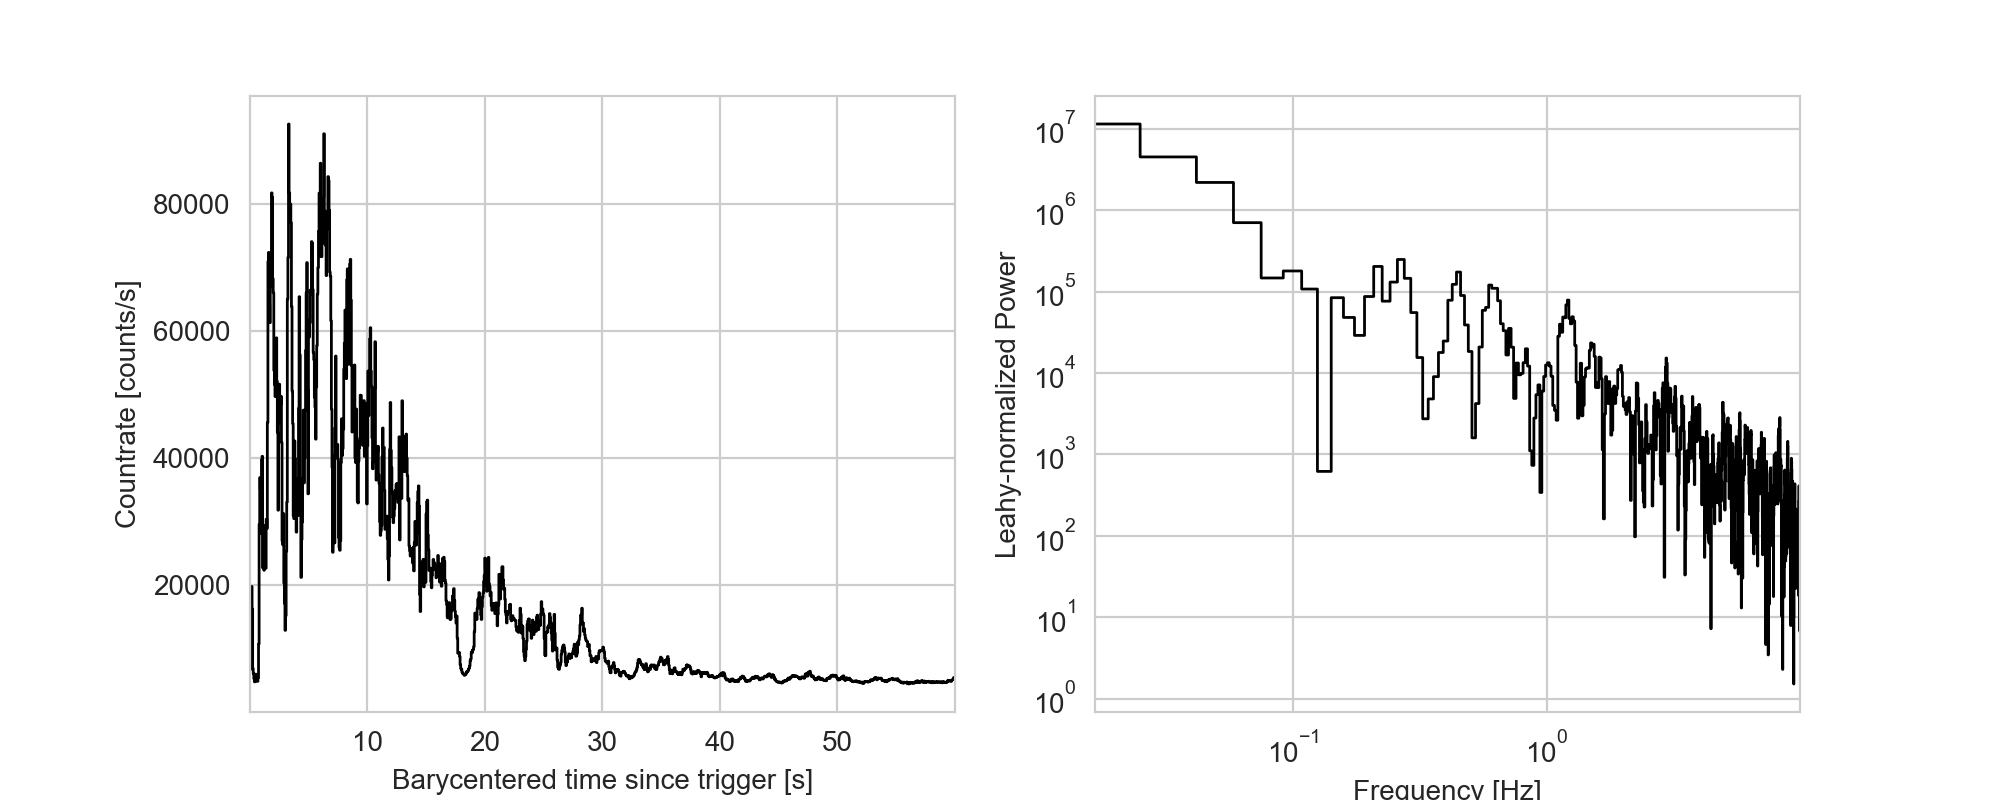

Text(0, 0.5, 'Leahy-normalized Power')

In [4]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4))

ax1.plot(lc.time, lc.counts, lw=1, color="black", ds="steps-mid")
ax1.set_xlim(lc.time[0], lc.time[-1])
ax1.set_xlabel("Barycentered time since trigger [s]")
ax1.set_ylabel("Countrate [counts/s]")

ax2.loglog(ps.freq, ps.power, ds="steps-mid", lw=1, color="black")
ax2.set_xlim(ps.freq[0], ps.freq[-1])
ax2.set_xlabel("Frequency [Hz]")
ax2.set_ylabel("Leahy-normalized Power")

In [313]:
lc.dt

0.04999971389770508

## Draft Function that *might* be useful

Not sure yet whether I need the function below

In [6]:
def neg_param_ll(log_params, t, y, gp, mean, 
                 n_mean_params, p=1, q=0):
    """
    Negative log likelihood function for CARMA specified in the nominal space.

    This method will catch 'overflow/underflow' runtimeWarning and
    return inf as probability.

    Parameters
    ----------
        log_params :  (array(float))
            Natural log of CARMA parameters.
            
        y : (array(float))
            y values of the input time series.
            
        gp : (celerite.GP object)
            celerite Gaussian Process object with a proper CARMA kernel.
        
        mean : function
            A mean function
        
        n_mean_params : int
            the number of parameters in `log_params` that belong 
            to the mean function
            
        p, q = int, int, defaults (1, 0)
            The order of the AR and MA processes in the CARMA 
            kernel

    Returns
    --------
        loglike: float
            negative log likelihood.
    """
    
    dummy_params = sample_carma(p, q)

    assert p <= 2, "Use neg_fcoeff_ll() instead!"
    neg_ll = np.inf

    mean_params = log_params[:n_mean_params]
    
    mean_vals = mean(t, mean_params)
    
    try:
        if p == 1 and q == 0:
            #kernel = DRW_term(np.log(amp), np.log(tau))
            gp = GP(DRW_term(*np.log(dummy_params)), mean=mean_vals)
            gp.set_parameter_vector(log_params[n_mean_params:])
        elif p <= 2 and q <= 1:
            kernel = CARMA_term(*np.log(dummy_params))
            gp = GP(kernel, mean=mean_vals)
            gp.set_parameter_vector(log_params[n_mean_params:])
        else:
            return ValueError("Do not use this for p>2 and q>1!")
            #kernel = CARMA_term(*np.log(dummy_params), mean=mean_vals)
            #gp = GP(kernel, mean=mean_vals)
            #gp.kernel.set_log_fcoeffs(log_params[n_mean_params:])
            
        neg_ll = -gp.log_likelihood(y)
    except celerite.solver.LinAlgError as c:
        # print(c)
        pass
    except Exception as e:
        pass

    return neg_ll



## (Multiplicative) CARMA in EzTAO and Celerite

We'll use EzTAO to try and fit a CARMA process:

In [7]:
from celerite import GP
from eztao.ts import neg_param_ll
from eztao.ts import sample_carma
from eztao.carma import CARMA_term


In [8]:
from eztao.ts import gpSimFull, gpSimByTime, addNoise
from celerite.modeling import Model


In [9]:
class SkewGaussian(Model):
    parameter_names = ("A", "t0", "sig1", "sig2", "const")

    def get_value(self, t):
        y = self.A * np.where(
                t > self.t0,
                np.exp(-((t - self.t0) ** 2) / (2 * (self.sig2**2))),
                np.exp(-((t - self.t0) ** 2) / (2 * (self.sig1**2))),
            )
        return y + self.const

INFO[2023-10-05 15:50:30,753]: Checking if light curve is well behaved. This can take time, so if you are sure it is already sorted, specify skip_checks=True at light curve creation.


(array([1.28963706e+03, 1.25851056e-02]), array([0.00201691, 0.00328985]))
[0.35682832 0.34568132 0.34866469 ... 0.88783841 0.95919502 0.98626822]
2492.3009078523974


INFO[2023-10-05 15:50:31,002]: Checking if light curve is sorted.
INFO[2023-10-05 15:50:31,005]: Computing the bin time ``dt``. This can take time. If you know the bin time, please specify it at light curve creation


<IPython.core.display.Javascript object>


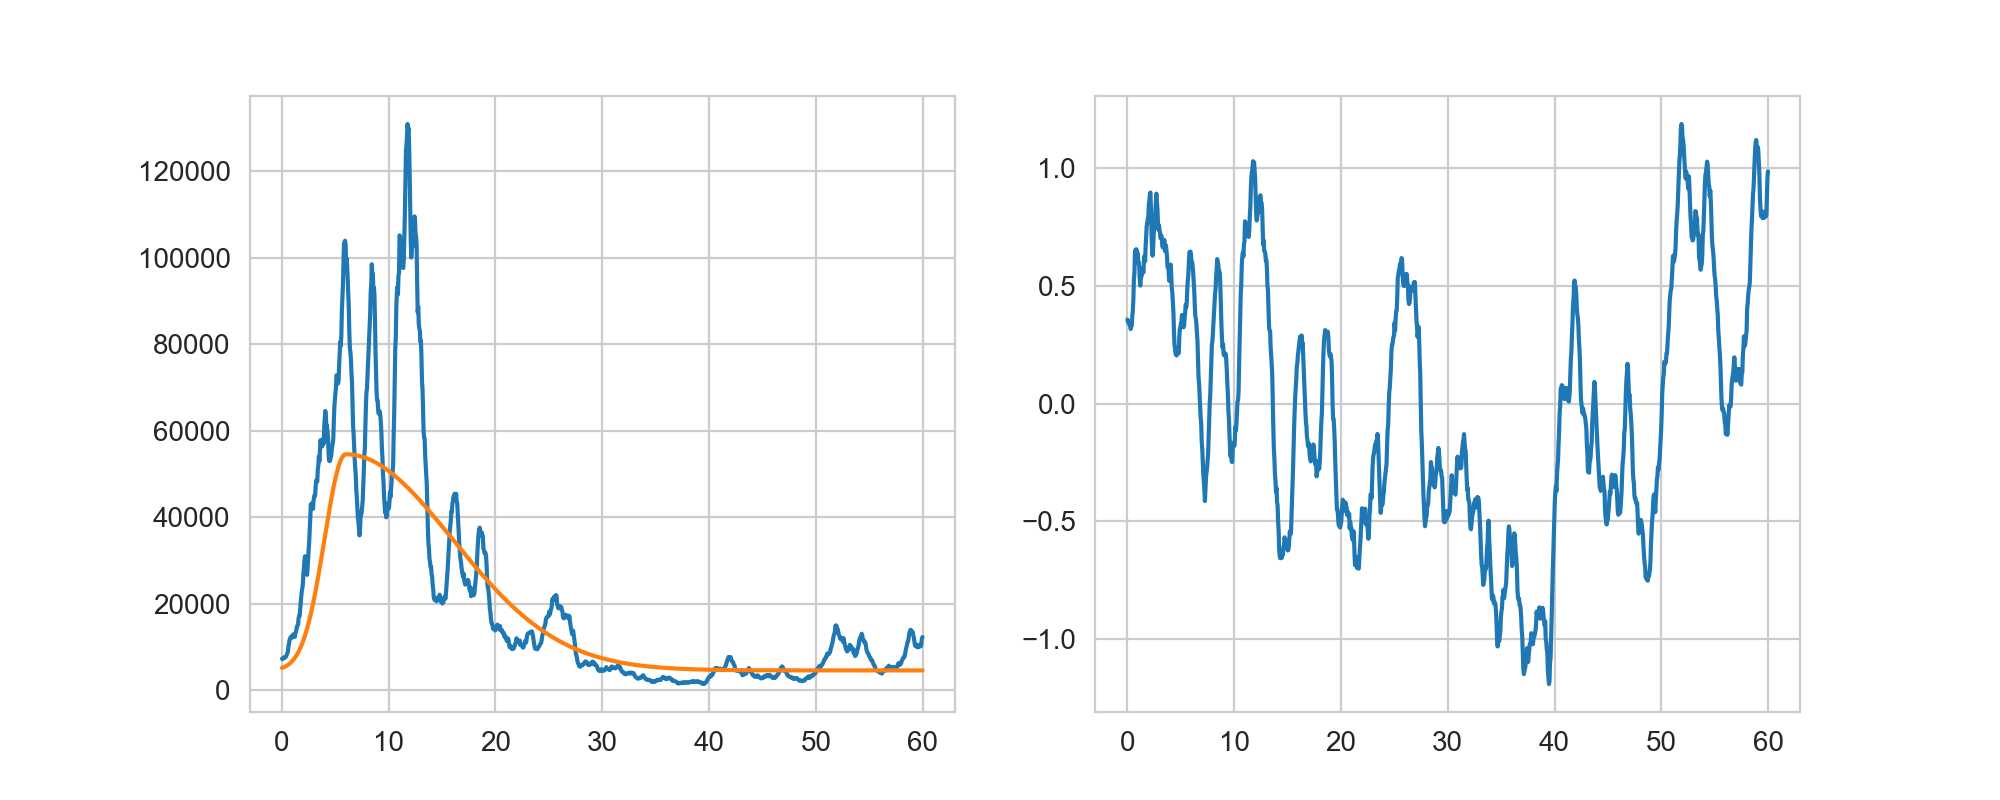

In [10]:

np.random.seed(200)

p = 2
q = 1 

carma_params = sample_carma(p, q)
print(carma_params)

carma_params = [[4.0, 2.0], [2.0, 0.1]]

skew_amp = 50000
skew_t0 = 6.0
skew_sig1 = 2.0
skew_sig2 = 10.0
skew_const = mean_bkg

mean_model = SkewGaussian(A=skew_amp, t0=skew_t0, 
                          sig1=skew_sig1, sig2=skew_sig2,
                          const = skew_const)
mean_vals = mean_model.get_value(lc.time)

kernel = CARMA_term(*np.log(carma_params))
gp = GP(kernel, mean=0.0)
gp.compute(lc.time, lc.counts_err)
sample = gp.sample()
print(sample)

print(gp.log_likelihood(sample))

sample_comb = np.exp(sample) * mean_vals
sample_counts = np.random.poisson(sample_comb)
#sample_counts = sample_comb

lcsample = Lightcurve(lc.time, sample_counts)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4))

ax1.plot(lcsample.time, lcsample.counts)
ax1.plot(lcsample.time, mean_vals)

ax2.plot(lcsample.time, sample)

I think the process we're looking it probably needs to be multiplicative, 
otherwise it's really hard to explain the dependence of the variation 
amplitude with flux. So let's build a multiplicative likelihood:

In [11]:

log_err = np.sqrt(lcsample.counts) / (lcsample.counts)

In [12]:
log_err

array([0.01174602, 0.01178921, 0.01162241, ..., 0.00947921, 0.00912263,
       0.0090222 ])

<IPython.core.display.Javascript object>


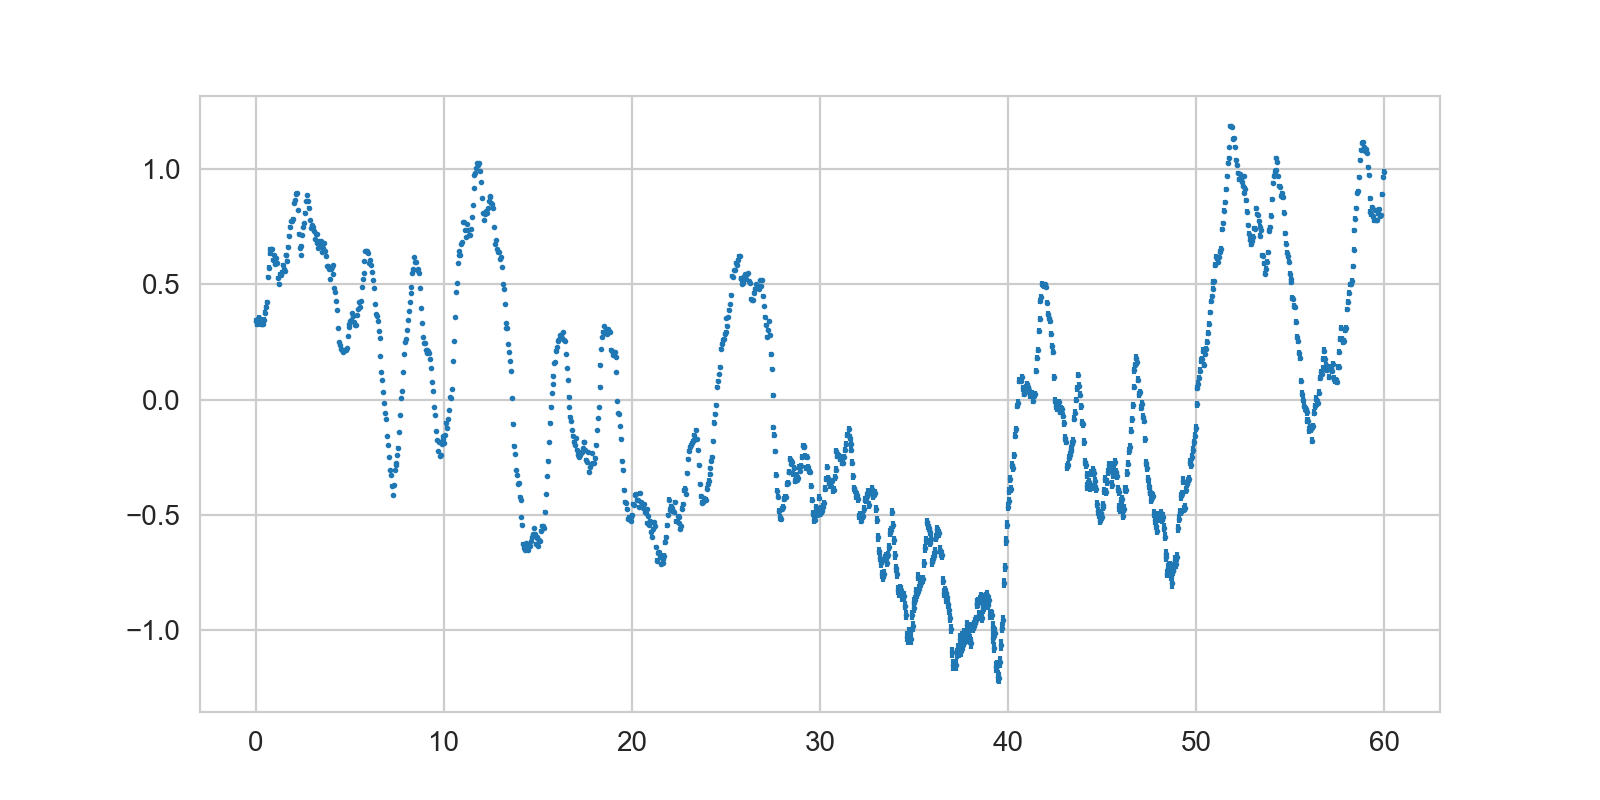

<ErrorbarContainer object of 3 artists>

In [13]:
log_residuals = np.log(lcsample.counts/mean_vals)
fig, ax = plt.subplots(1, 1, figsize=(8,4))

ax.errorbar(lcsample.time, log_residuals, yerr=log_err, fmt="o", markersize=1)

Ok, cool. I think that's fine. Let's see if I can model this with a Gaussian Process?

In [14]:
log_err

array([0.01174602, 0.01178921, 0.01162241, ..., 0.00947921, 0.00912263,
       0.0090222 ])

In [15]:
kernel = CARMA_term(*np.log(carma_params))
gp = GP(kernel, mean=0.0)
gp.compute(lcsample.time, log_err)

In [16]:
gp.log_likelihood(sample)

2420.576171413816

In [17]:
# Define a cost function
def neg_log_like(params, y, gp):
    #print(params)
    gp.set_parameter_vector(params)
    try:
        loglike = -gp.log_likelihood(y)
        #print(loglike)
        if not np.isfinite(loglike):
            return 1e10
        else:
            return loglike
    except:
        #print(loglike)
        return 1e10


In [18]:
np.hstack(carma_params)

array([4. , 2. , 2. , 0.1])

In [19]:
from scipy.optimize import minimize

In [21]:
stacked_params = np.log(np.hstack(carma_params))
initial_params = np.random.normal(stacked_params, np.abs(stacked_params)/5)
print(initial_params)
bounds = gp.get_parameter_bounds()
soln = minimize(neg_log_like, stacked_params,
                method="L-BFGS-B", bounds=bounds, args=(sample, gp))
gp.set_parameter_vector(soln.x)
print(soln.x)
print(soln.message)
print(stacked_params)

[ 0.90536317  0.44556428  0.65631453 -1.59242527]
[ 1.41147048  0.47411316  0.71937402 -2.6178812 ]
CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
[ 1.38629436  0.69314718  0.69314718 -2.30258509]


In [22]:
gp.set_parameter_vector(soln.x)

0.028140309484375514


<IPython.core.display.Javascript object>


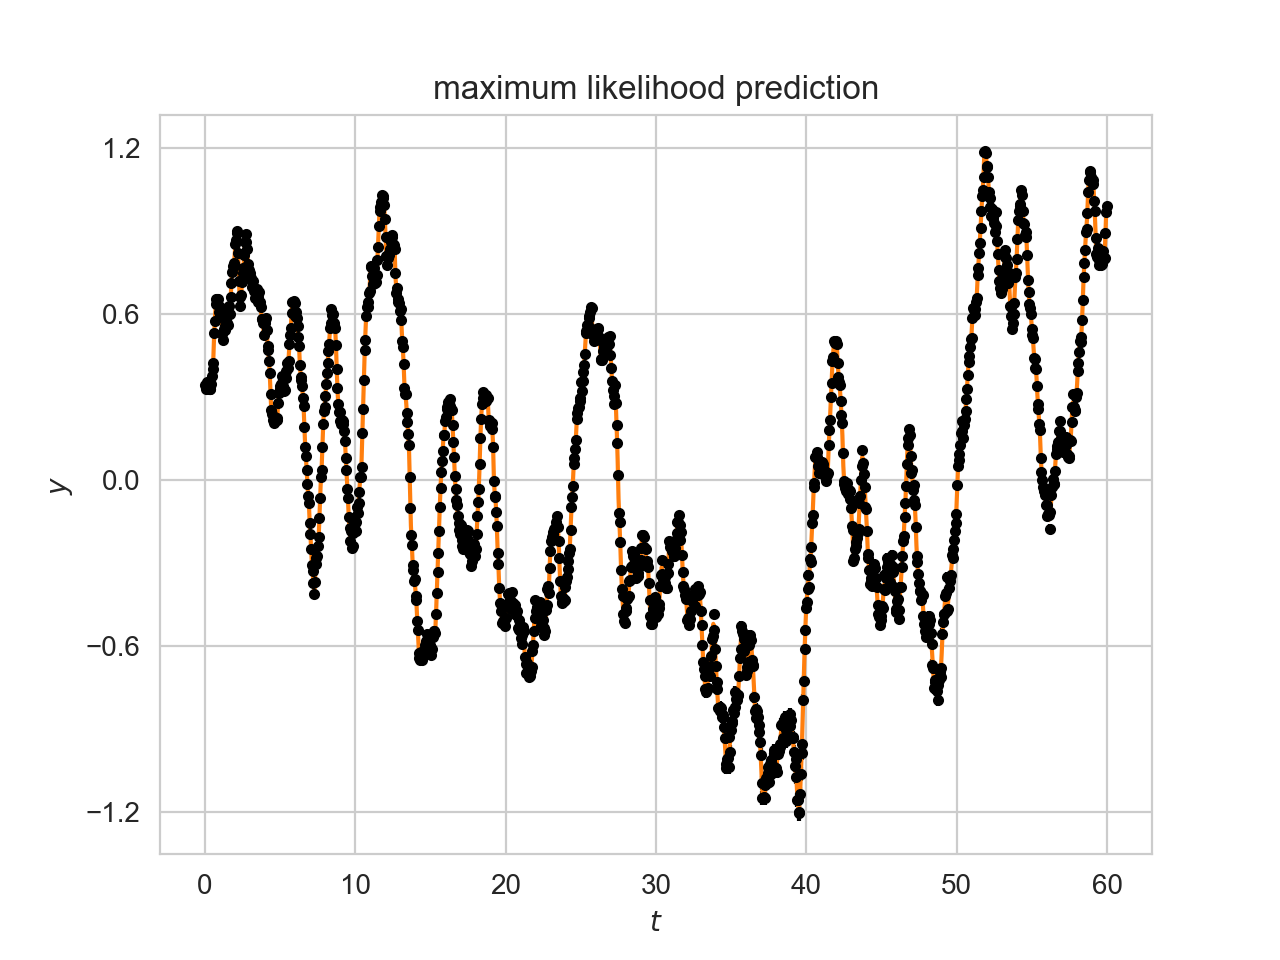

In [23]:
t = np.linspace(lc.time[0], lc.time[-1], 1000)
mu, var = gp.predict(log_residuals, t, return_var=True)
std = np.sqrt(var)

print(t[0])
plt.figure()
color = "#ff7f0e"
plt.errorbar(lcsample.time, log_residuals, yerr=log_err, fmt=".k", capsize=0)
plt.plot(t, mu, color=color)
plt.fill_between(t, mu+std, mu-std, color=color, alpha=0.3, edgecolor="none")
plt.ylabel(r"$y$")
plt.xlabel(r"$t$")
#plt.xlim(-5, 5)
plt.gca().yaxis.set_major_locator(plt.MaxNLocator(5))
plt.title("maximum likelihood prediction");


In [24]:
def log_probability(params):
    #print(params)
    gp.set_parameter_vector(params)
    lp = gp.log_prior()
    
    if np.any(params < 0):
        return -np.inf
    if not np.isfinite(lp):
        return -np.inf
    loglike = gp.log_likelihood(log_residuals)
    print(loglike)
    return  loglike + lp


In [25]:
import emcee

initial = np.array(soln.x)
ndim, nwalkers = len(initial), 32
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability)

In [26]:
print("Running burn-in...")
p0 = initial + 1e-4 * np.random.randn(nwalkers, ndim)
#print(p0)
p0, lp, _ = sampler.run_mcmc(p0, 500)

Running burn-in...


In [27]:
print("Running production...")
sampler.reset()
sampler.run_mcmc(p0, 2000);


Running production...


<IPython.core.display.Javascript object>


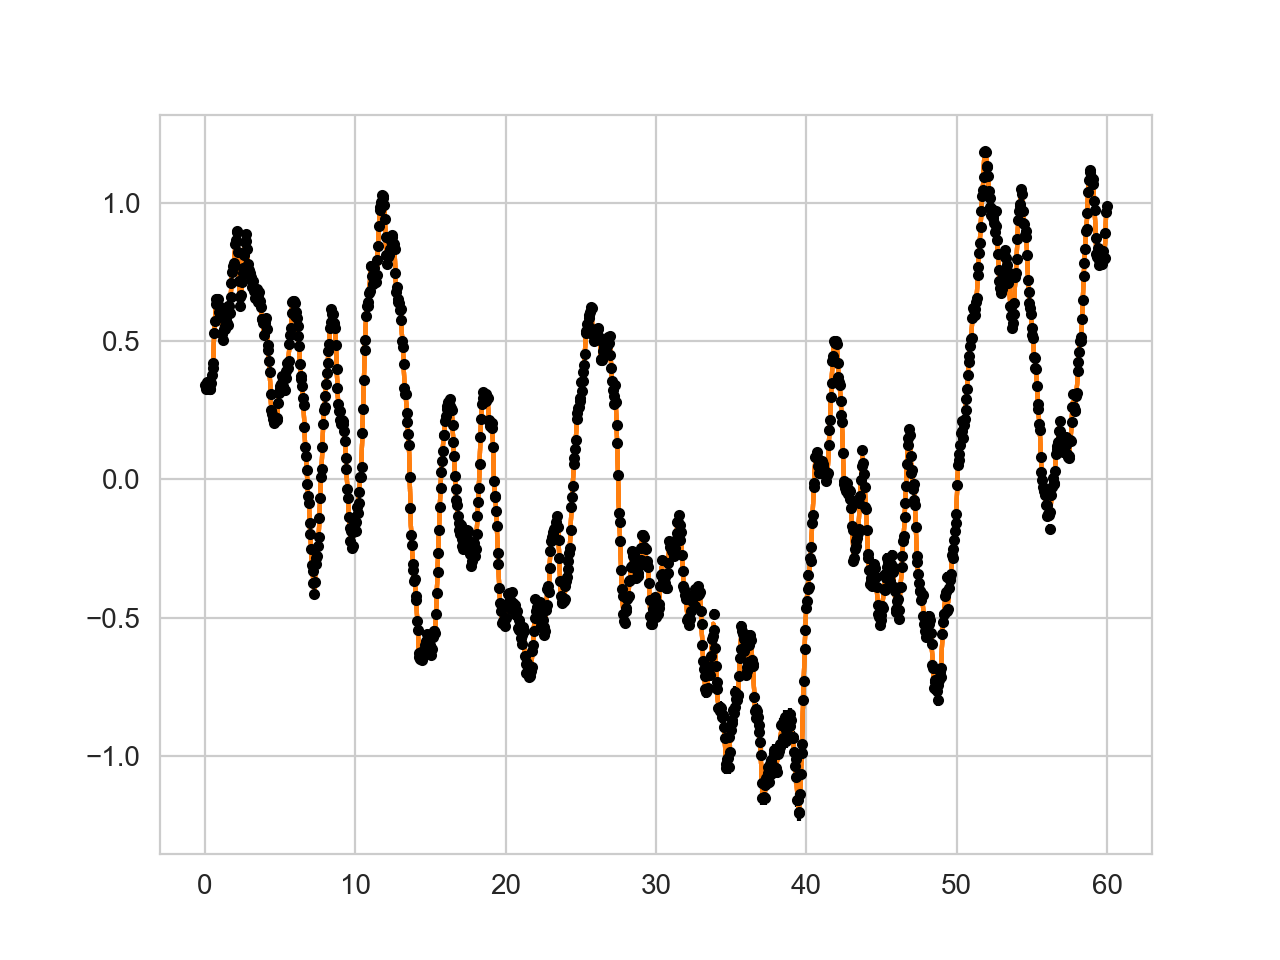

In [28]:
plt.figure()
plt.errorbar(lcsample.time, log_residuals, yerr=log_err, fmt=".k", capsize=0)

# Plot 24 posterior samples.
samples = sampler.flatchain
for s in samples[np.random.randint(len(samples), size=24)]:
    gp.set_parameter_vector(s)
    mu = gp.predict(log_residuals, t, return_cov=False)
    #print(mu)
    plt.plot(t, mu, color=color, alpha=0.3)



### A better multiplicative model, with log-parameters and priors

In order to sample this effectively, we need to make some parameters log-parameters, and we need reasonable priors so the sampler doesn't run off:


In [29]:
class SkewGaussian(Model):
    parameter_names = ("logA", "t0", "logsig1", "logsig2", "logconst")

    def get_value(self, t):
        y = np.exp(self.logA) * np.where(
                t > self.t0,
                np.exp(-((t - self.t0) ** 2) / (2 * (np.exp(self.logsig2)**2))),
                np.exp(-((t - self.t0) ** 2) / (2 * (np.exp(self.logsig1)**2))),
            )
        return y + np.exp(self.logconst)

Let's re-generate the data:

INFO[2023-10-05 15:52:26,977]: Checking if light curve is well behaved. This can take time, so if you are sure it is already sorted, specify skip_checks=True at light curve creation.
INFO[2023-10-05 15:52:26,978]: Checking if light curve is sorted.
INFO[2023-10-05 15:52:26,978]: Computing the bin time ``dt``. This can take time. If you know the bin time, please specify it at light curve creation


(array([1.28963706e+03, 1.25851056e-02]), array([0.00201691, 0.00328985]))
[0.35682832 0.34568132 0.34866469 ... 0.88783841 0.95919502 0.98626822]
2492.3009078523974


<IPython.core.display.Javascript object>


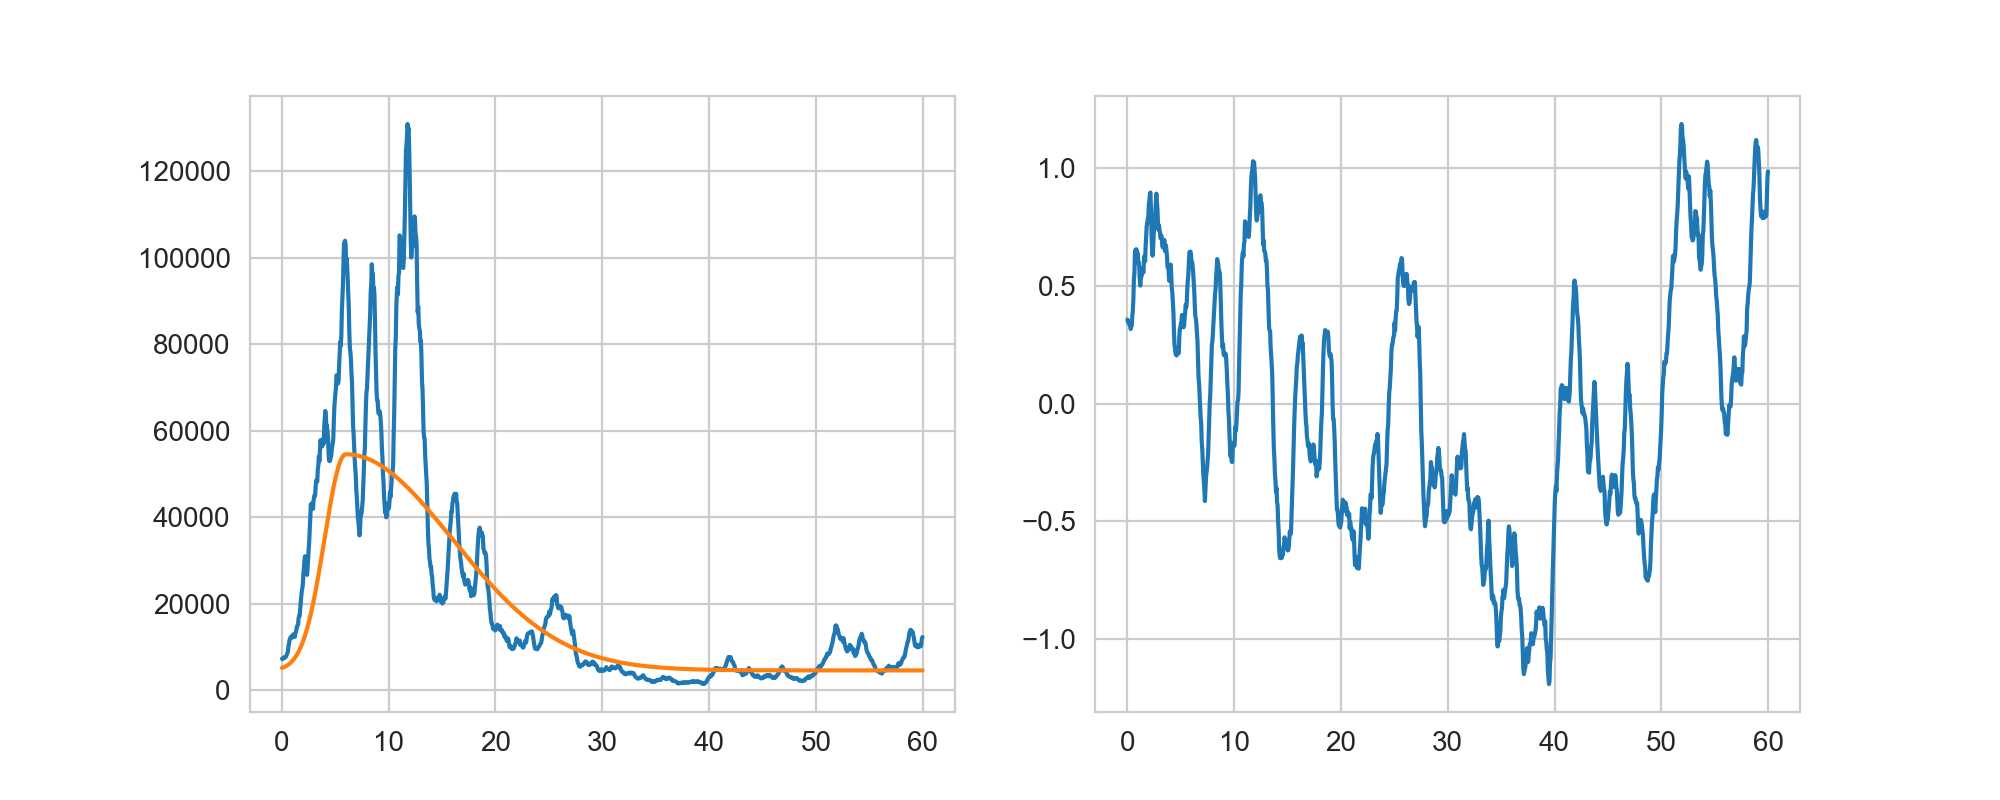

In [30]:
np.random.seed(200)

p = 2
q = 1 

carma_params = sample_carma(p, q)
print(carma_params)

carma_params = [[4.0, 2.0], [2.0, 0.1]]

skew_amp = np.log(50000)
skew_t0 = 6.0
skew_sig1 = np.log(2.0)
skew_sig2 = np.log(10.0)
skew_const = np.log(mean_bkg)

mean_model = SkewGaussian(logA=skew_amp, t0=skew_t0, 
                          logsig1=skew_sig1, logsig2=skew_sig2,
                          logconst = skew_const)

mean_vals = mean_model.get_value(lc.time)

true_kernel_params = np.log(np.hstack(carma_params))
true_mean_params = [skew_amp, skew_t0, skew_sig1, skew_sig2, skew_const]

true_params = np.hstack([true_mean_params, true_kernel_params])

kernel = CARMA_term(*np.log(carma_params))
gp = GP(kernel, mean=0.0)
gp.compute(lc.time, lc.counts_err/lc.counts)
sample = gp.sample()
print(sample)

print(gp.log_likelihood(sample))

sample_comb = np.exp(sample) * mean_vals
sample_counts = np.random.poisson(sample_comb)
#sample_counts = sample_comb

log_err = np.sqrt(sample_counts) / sample_counts

lcsample = Lightcurve(lc.time, sample_counts, counts_err=log_err)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4))

ax1.plot(lcsample.time, lcsample.counts)
ax1.plot(lcsample.time, mean_vals)

ax2.plot(lcsample.time, sample)


Okay, now let's set up the model:

In [31]:
# set up kernel and GP
kernel = CARMA_term(*np.log(carma_params))
gp = GP(kernel, mean=0.0)
gp.compute(lc.time, lc.counts_err)

mean_model = SkewGaussian(logA = skew_amp, t0=skew_t0, 
                          logsig1 = skew_sig1, logsig2 = skew_sig2,
                          logconst = skew_const)

gp.log_likelihood(log_residuals)

2141.338281459376

Now let's set up the priors:

In [32]:
def log_prior(params):

    # priors for mean parameters:
    # ('logA', 't0', 'logsig1', 'logsig2', 'logconst')
    
    # NOTE: UNIFORM DISTRIBUTION IS DEFINED AS 
    # loc, loc+scale rather than (min, max)
    p_loga = (params[0] >= 8) & (params[0] <= 15) #scipy.stats.uniform(1, 14).logpdf(params[0])
    p_t0 = (params[1] >= 0.1) & (params[1] <= 20)#scipy.stats.uniform(0, 20).logpdf(params[1])
    p_logsig1 = (params[2] >= -3) & (params[2] <= 1.0)#scipy.stats.uniform(-3, 7.0).logpdf(params[2])

    p_logsig2 = (params[3] >= 1.0) & (params[3] <= 4)#scipy.stats.uniform(-3, 7.0).logpdf(params[3])
    p_logconst = (params[4] >= 7) & (params[4] <= 10)#scipy.stats.uniform(1, 9).logpdf(params[4])

    #print(p_loga)
    #print(p_t0)
    #print(p_logsig1)
    #print(p_logsig2)
    #print(p_logconst)
    # priors for CARMA parameters
    p_carma = np.zeros_like(params[5:])
    for i,p in enumerate(params[5:]):
        p_carma[i] = (p >= -3) & (p <= 3)#scipy.stats.uniform(-3, 6).logpdf(p)
        #print(p_carma[i])
        
    # sum it all up
    lp = np.sum(np.log(p_carma)) + np.sum(np.log([p_loga, p_t0, p_logsig1, 
                                     p_logsig2, p_logconst]))
    
    return lp

In [50]:
time = lcsample.time
counts = lcsample.counts

In [33]:
def log_probability(params):
    #print(params)
    # get the number of parameters in the mean model
    n_mean_params = len(mean_model.get_parameter_names())
    mean_params = params[:n_mean_params]
    
    # get the mean model fluxes
    mean_model.set_parameter_vector(mean_params)
    mean_vals = mean_model.get_value(time)
    
    # compute log-residuals after dividing out mean model
    log_residuals = np.log(counts/mean_vals)
    
    # set kernel parameters
    kernel_params = params[n_mean_params:]
    gp.set_parameter_vector(kernel_params)
    lpgp = gp.log_prior()
    #print(lpgp)
    #print(log_prior(params))
    lp = log_prior(params) #+ lpgp


    if not np.isfinite(lp):
        #print(-np.inf)
        return -np.inf
    try:
        loglike = gp.log_likelihood(log_residuals)
    except:
        #print(-np.inf)
        return -np.inf

    #print(loglike)
    #print(lp)
    #print("\n")
    return  loglike + lp


In [36]:
print(log_probability(true_params + 0.01 * np.random.randn(len(true_params))))

2139.574357640906


In [37]:
import emcee

initial = true_params
ndim, nwalkers = len(initial), 32
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability)

p0 = initial + 0.01 * np.random.randn(nwalkers, ndim)

In [38]:
for ptest in p0:
    print(log_probability(ptest))

2153.9372997244227
2136.784637709524
2135.500359037853
2141.4898445807466
2134.849746363463
2138.8842252108507
2142.634748180966
2148.2322898912344
2140.8769753146107
2141.0579136670367
2131.8737166232168
2146.7070003299905
2140.4515529185637
2138.296339456864
2146.682119543547
2135.184046762992
2142.726489256819
2144.53203715415
2147.9498547923577
2145.59801691759
2132.1808625629783
2142.3067066568874
2140.327223104042
2139.3164947529012
2141.170790273419
2145.919616390567
2144.9835065130565
2143.79009443985
2128.81567406031
2137.359876039015
2134.099017567787
2147.5269613828623


In [39]:
print("Running burn-in...")

#print(p0)
p0, lp, _ = sampler.run_mcmc(p0, 1000)

Running burn-in...


In [40]:
print("Running production...")
sampler.reset()
sampler.run_mcmc(p0, 10000);


Running production...


In [41]:
chains = sampler.get_chain()

<IPython.core.display.Javascript object>


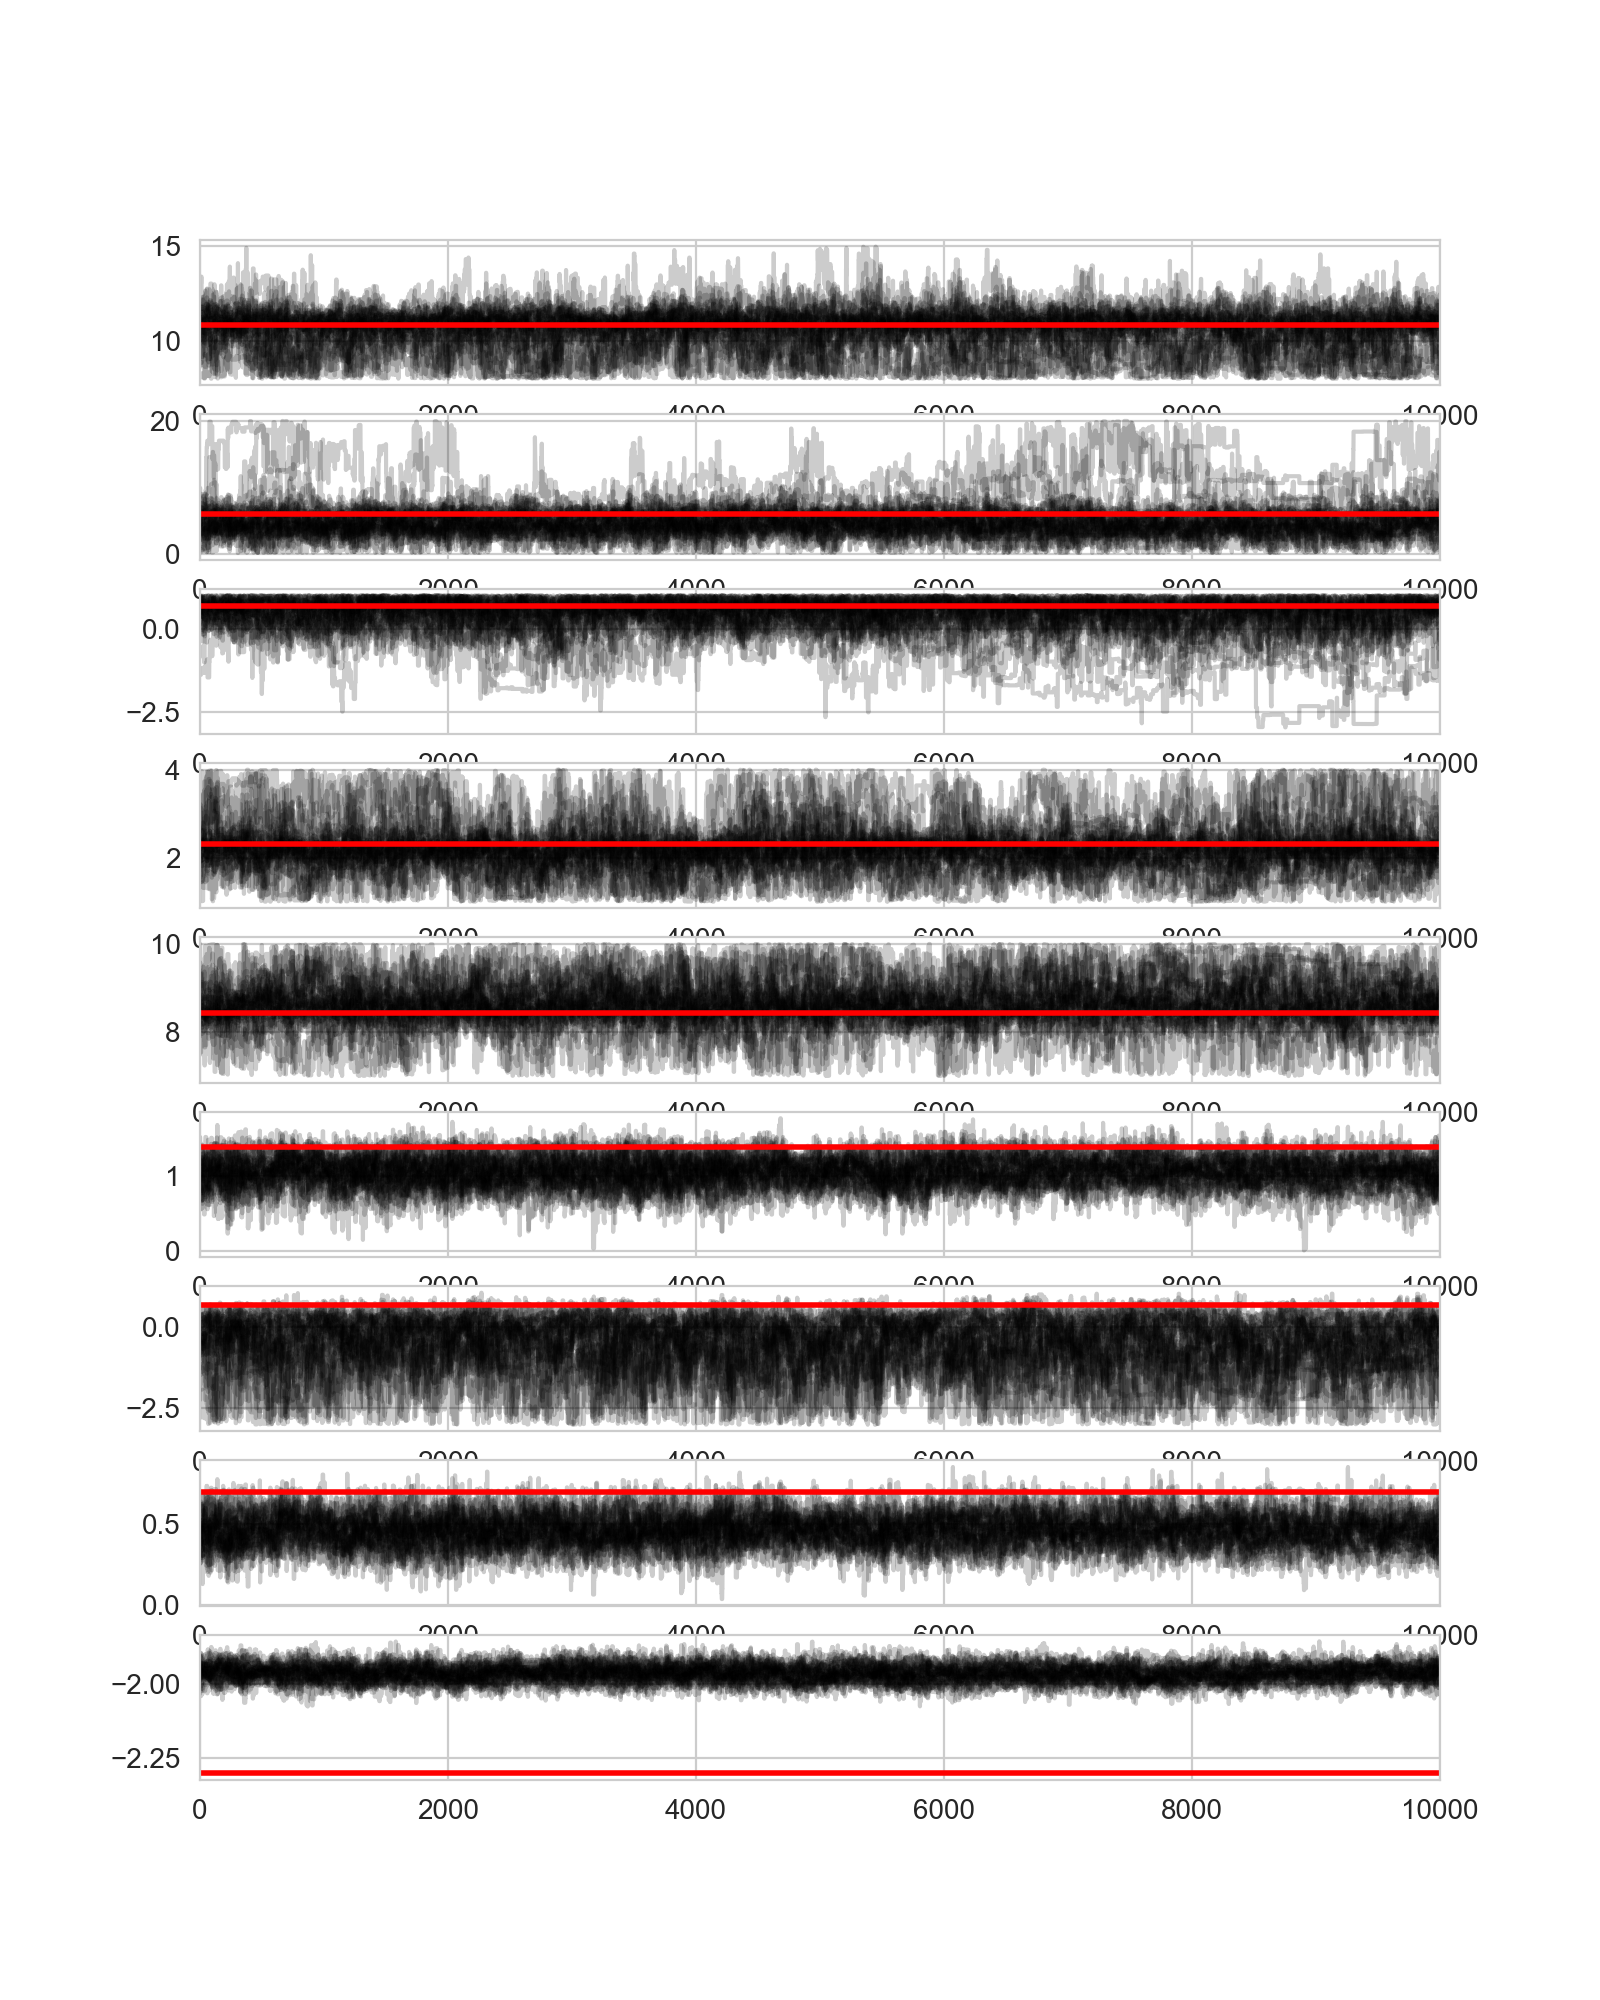

In [42]:
fig, axes = plt.subplots(9, 1, figsize=(8,10))

axes = np.hstack(axes)

for i in range(ndim):
    axes[i].plot(chains.T[i,:,:].T, alpha=0.2, color="black")
    axes[i].set_xlim(0, chains.T[i,:,:].shape[1])
    axes[i].axhline(true_params[i], color="red", lw=2)

array([2221.78309053, 2220.91342827, 2225.89669743, ..., 2222.16278135,
       2225.18075254, 2222.87331522])

<IPython.core.display.Javascript object>


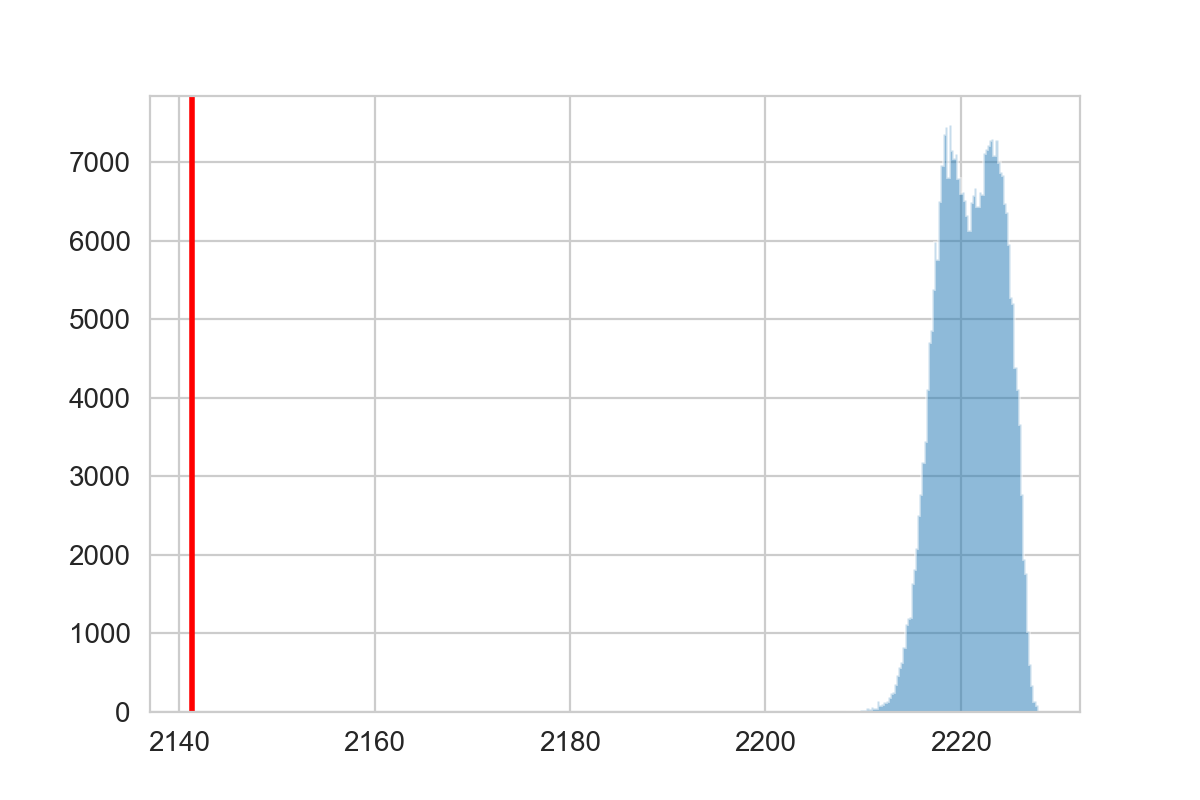

In [48]:
fig, ax = plt.subplots(1, 1, figsize=(6,4))

ax.hist(sampler.flatlnprobability, bins=100, histtype="stepfilled", alpha=0.5)

ax.axvline(log_probability(true_params), lw=2, color="red")

Okay, so why is the log-probability higher further away from the true value?? This makes me sad!

<IPython.core.display.Javascript object>


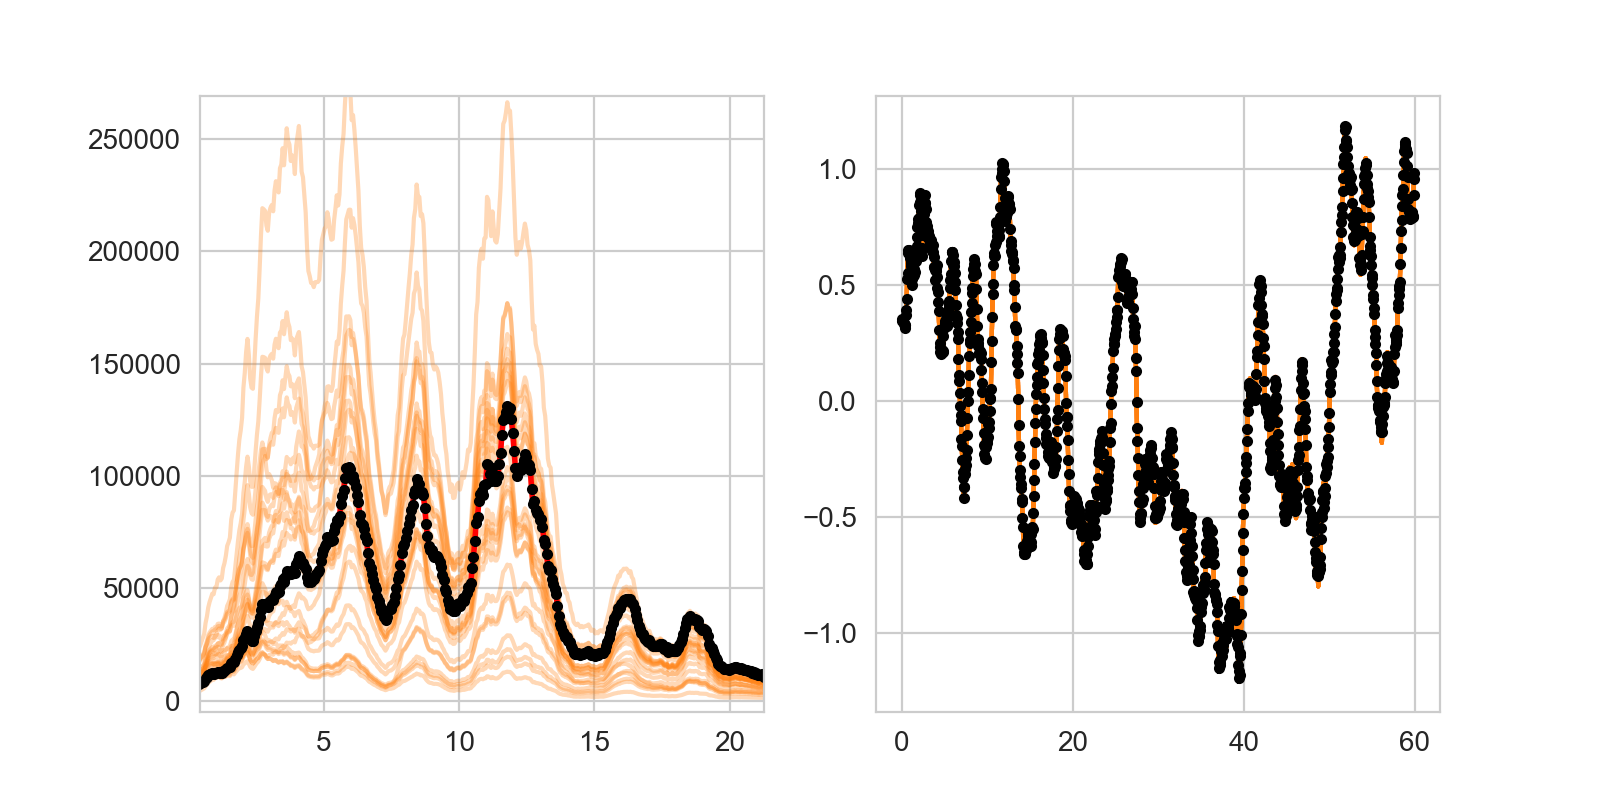

In [49]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8,4))

ax1.errorbar(lcsample.time, lcsample.counts, yerr=log_err, fmt=".k", capsize=0)
ax2.errorbar(lcsample.time, sample, yerr=log_err, fmt=".k", capsize=0)

n_mean_params = len(mean_model.get_parameter_names())

# Plot 24 posterior samples.
samples = sampler.flatchain

mod_all = []
for s in samples[np.random.randint(len(samples), size=24)]:
    #print(s)
    ms = s[:n_mean_params]
    ks = s[n_mean_params:]
    
    mean_model.set_parameter_vector(ms)
    mval = mean_model.get_value(time)
    
    gp.set_parameter_vector(ks)
    mu = gp.predict(log_residuals, time, return_cov=False)
    
    mod = np.exp(mu) * mval
    #print(mu)
    ax1.plot(time, mod, color=color, alpha=0.3)
    ax2.plot(time, mu, color=color, alpha=0.3)
    mod_all.append(mod)
    
mod_mean = np.mean(mod_all, axis=0)

mean_model.set_parameter_vector(true_params[:n_mean_params])
true_mean_vals = mean_model.get_value(time)

gp.set_parameter_vector(true_params[n_mean_params:])
true_gp = gp.predict(log_residuals, time, return_cov=False)

true_mod = np.exp(true_gp) * true_mean_vals

ax1.plot(time, true_mod, lw=2, color="red")


Okay, that doesn't seem to be working *super* well.

Alternative option: tinygp.CARMA process + a latent model + numpyro?

## Latent GP Model with CARMA + Numpyro

In [54]:
import numpyro
import numpyro.distributions as dist
from tinygp import kernels, GaussianProcess

from tinygp.kernels.quasisep import CARMA

jax.config.update("jax_enable_x64", True)

In [60]:
def skewgaussian(t, params):
    #parameter_names = ("logA", "t0", "logsig1", "logsig2", "logconst")
    logA = params[0]
    t0 = params[1]
    logsig1 = params[2]
    logsig2 = params[3]
    logconst = params[4]

    y = jnp.sum(
        jnp.exp(logA)
        * jnp.where(
            t > t0,
            jnp.exp(-((t - t0) ** 2) / (2 * (jnp.exp(logsig2)**2))),
            jnp.exp(-((t - t0) ** 2) / (2 * (jnp.exp(logsig1)**2))),
        ),
        axis=0,
    )
    return y + jnp.exp(logconst)

Let's generate some data:

INFO[2023-10-05 18:44:11,544]: Checking if light curve is well behaved. This can take time, so if you are sure it is already sorted, specify skip_checks=True at light curve creation.
INFO[2023-10-05 18:44:11,545]: Checking if light curve is sorted.
INFO[2023-10-05 18:44:11,546]: Computing the bin time ``dt``. This can take time. If you know the bin time, please specify it at light curve creation


-758040.9313986952


<IPython.core.display.Javascript object>


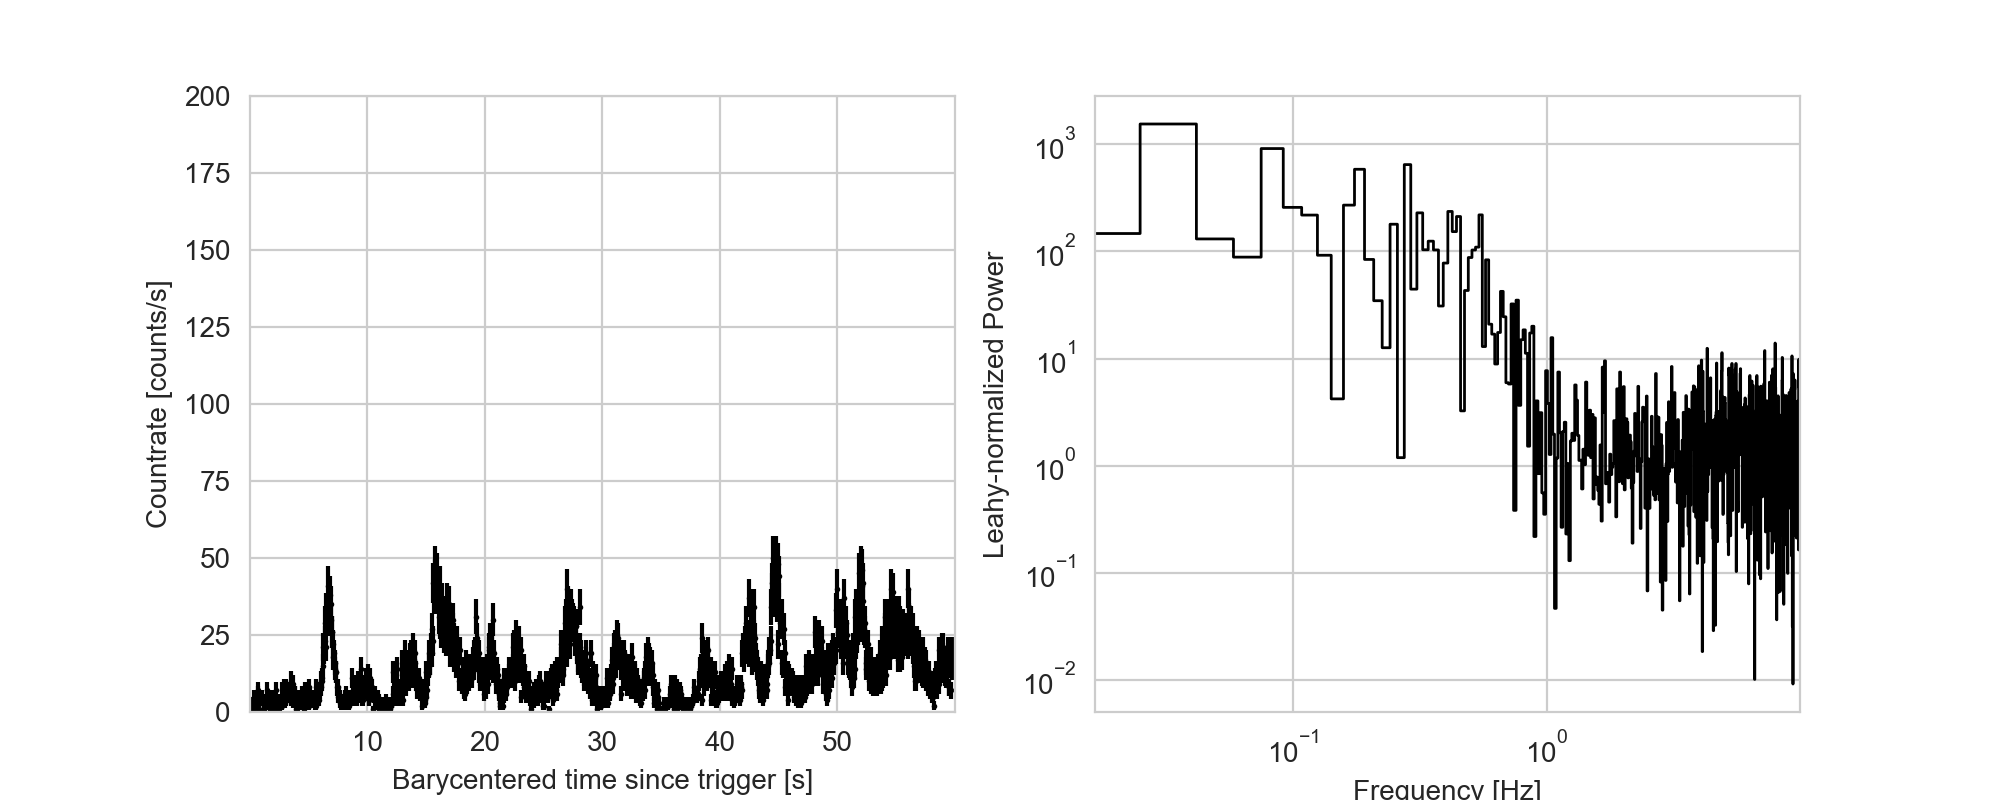

<IPython.core.display.Javascript object>


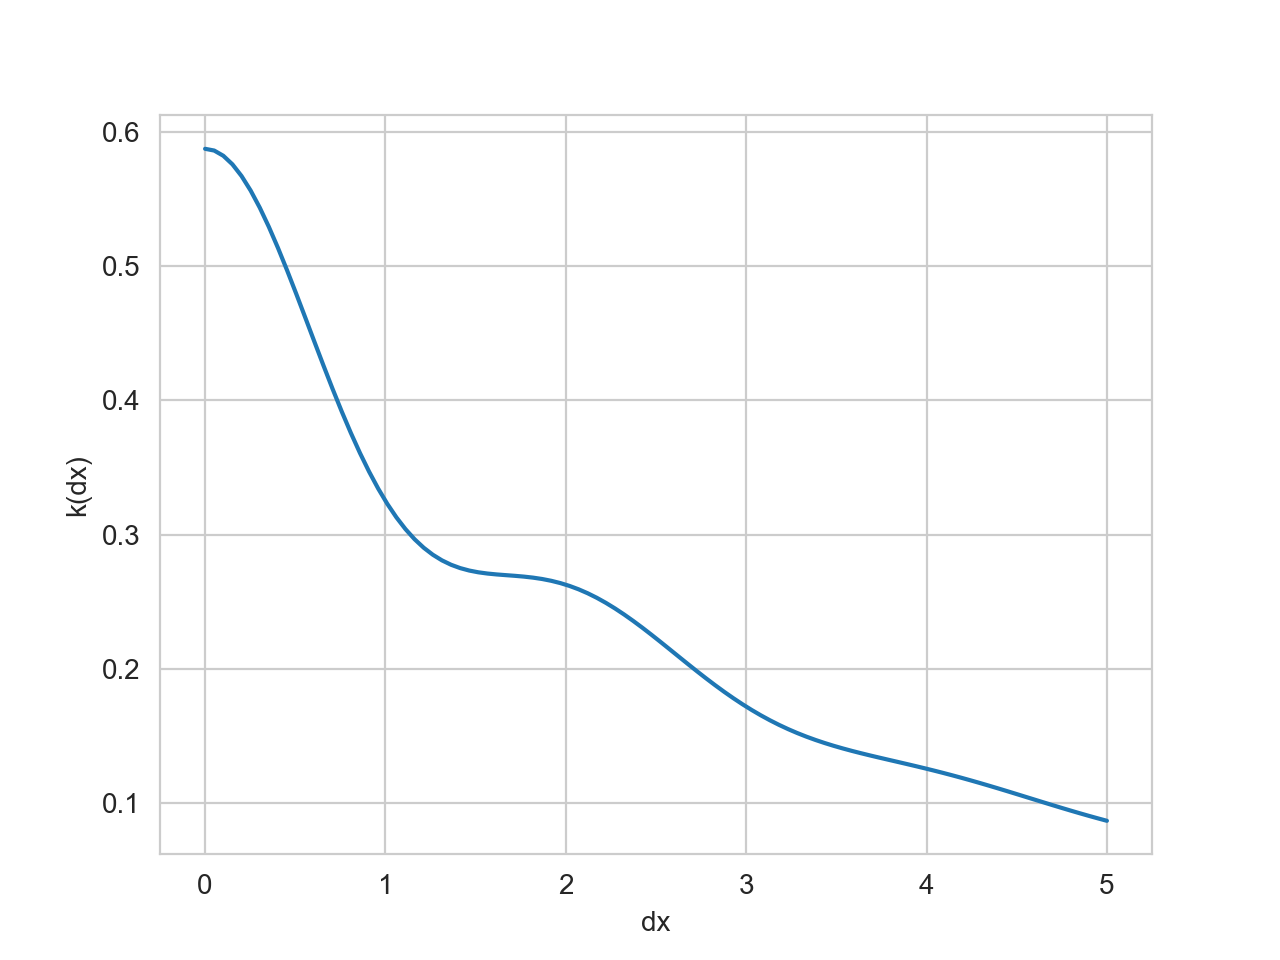

In [173]:
#alpha = [.8, 1.2, 1.7]
#beta = [1.5]
#sigma = 1e5

alpha = [3.5, 10.5, 2.0]
beta = [1.5]
sigma = 4

skew_amp = 10
skew_t0 = 6.0
skew_sig1 = 2.0
skew_sig2 = 10.0


kernel_params_true = {"alpha": alpha,
                      "beta": beta,
                      "acarma": sigma}
mean_params_true = {"A": skew_amp, 
                    "t0": skew_t0, 
                    "sig1": skew_sig1, 
                    "sig2": skew_sig2}

time = lc.time

#mean = _skew_gaussian(time, mean_params_true)
mean = np.ones_like(time)

kernel = CARMA.init(alpha=alpha, beta=beta, sigma=sigma)
gp = GaussianProcess(kernel, time, mean_value=mean, diag=0.01)

key = random.PRNGKey(100)
sample = np.exp(gp.sample(key) + mean)
#sample = gp.sample(key)
sample = np.random.poisson(sample)

#err = np.random.normal(0.0, np.sqrt(np.abs(sample)))
#sample = sample + err

gp.condition(sample)
print(gp.log_probability(sample))
lcsample = Lightcurve(time, sample)
pssample = Powerspectrum(lcsample, norm="leahy")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4))

ax1.errorbar(lcsample.time, lcsample.counts, yerr=np.sqrt(np.abs(lcsample.counts)), 
             fmt="o", markersize=1, color="black")
ax1.set_xlim(lcsample.time[0], lcsample.time[-1])
ax1.set_xlabel("Barycentered time since trigger [s]")
ax1.set_ylabel("Countrate [counts/s]")

ax2.loglog(pssample.freq, pssample.power, ds="steps-mid", lw=1, color="black")
ax2.set_xlim(pssample.freq[0], pssample.freq[-1])
ax2.set_xlabel("Frequency [Hz]")
ax2.set_ylabel("Leahy-normalized Power")
ax1.set_ylim(0, 200)
def plot_kernel(kernel, **kwargs):
    dx = np.linspace(0, 5, 100)
    plt.figure()
    plt.plot(dx, kernel(dx, dx[:1]), **kwargs)
    plt.xlabel("dx")
    plt.ylabel("k(dx)")


plot_kernel(kernel)

In [179]:
alpha = [3.5, 4.5, 2.0]
beta = [1.5]
sigma = 4

In [193]:
def model(x, y=None):
 
    # parameters for the mean function
    #loga = numpyro.sample("loga", dist.Uniform(8, 15))
    #t0 = numpyro.sample("t0", dist.Uniform(0.1, 20.0))
    #logsig1 = numpyro.sample("logsig1", dist.Uniform(-3, 1))
    #logsig2 = numpyro.sample("logsig2", dist.Uniform(1, 4))
    #logconst = numpyro.sample("logconst", dist.Uniform(7, 10))
    
    #mean_vals = skewgaussian(x, [loga, t0, logsig1, logsig2, logconst])

    # The parameters of the GP model    
    alpha1 = numpyro.sample("alpha1", dist.Uniform(3, 4))
    alpha2 = numpyro.sample("alpha2", dist.Uniform(10, 11))
    alpha3 = numpyro.sample("alpha3", dist.Uniform(1, 3))

    beta = numpyro.sample("beta", dist.Uniform(1, 2))
    sigma = numpyro.sample("sigma", dist.Uniform(3, 5))
    
    #print(alpha1)
    # Set up the kernel and GP objects
    kernel = CARMA.init([alpha1, alpha2, alpha3], [beta], sigma)
    gp = GaussianProcess(kernel, x, diag=0.01, mean=0.0)

    # This parameter has shape (num_data,) and it encodes our beliefs about
    # the process rate in each bin
    log_rate = numpyro.sample("log_rate", gp.numpyro_dist())

    # Finally, our observation model is Poisson
    numpyro.sample("obs", dist.Poisson(jnp.exp(log_rate)), obs=y)

    #numpyro.sample("gp", gp.numpyro_dist(), obs=y)

    #if y is not None:
    #    numpyro.deterministic("pred", gp.condition(y, x).gp.loc)


In [200]:
# Run the MCMC
nuts_kernel = numpyro.infer.NUTS(model, target_accept_prob=0.9)
mcmc = numpyro.infer.MCMC(
    nuts_kernel,
    num_warmup=1000,
    num_samples=1000,
    num_chains=4,
    progress_bar=True,
)

In [201]:

npoints = 300

rng_key = jax.random.PRNGKey(100)
mcmc.run(rng_key, time[:npoints], y=sample[:npoints])

sample: 100%|██████| 2000/2000 [11:05<00:00,  3.01it/s, 1023 steps of size 1.29e-04. acc. prob=0.88]


In [202]:
data = az.from_numpyro(mcmc)
az.summary(data, var_names=[v for v in data.posterior.data_vars if v != "log_rate"])

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
alpha1   3.580  0.178   3.293    3.768      0.088    0.068       4.0   
alpha2  10.464  0.252  10.084   10.785      0.124    0.095       5.0   
alpha3   2.265  0.283   1.857    2.651      0.137    0.104       5.0   
beta     1.479  0.181   1.206    1.755      0.088    0.067       4.0   
sigma    4.322  0.363   3.758    4.627      0.178    0.136       4.0   

        ess_tail  r_hat  
alpha1      11.0   3.66  
alpha2      14.0   2.97  
alpha3      16.0   2.61  
beta        11.0   3.54  
sigma       12.0   3.42

In [203]:
samples = mcmc.get_samples()

In [208]:
var_names = ["alpha1", "alpha2", "alpha3", "beta", "sigma"]
samples

{'alpha1': Array([3.31418098, 3.31272584, 3.3110011 , ..., 3.76484909, 3.76484444,
        3.76488156], dtype=float64),
 'alpha2': Array([10.29163731, 10.31074988, 10.3090492 , ..., 10.24674335,
        10.24678216, 10.24678306], dtype=float64),
 'alpha3': Array([2.41104531, 2.40736756, 2.39950308, ..., 1.85822139, 1.85811096,
        1.85806905], dtype=float64),
 'beta': Array([1.67685597, 1.68318154, 1.67988907, ..., 1.20737701, 1.20736852,
        1.20738051], dtype=float64),
 'log_rate': Array([[ 0.11482215,  0.31572425,  0.25131288, ...,  1.0535947 ,
          0.96467198,  0.86545804],
        [ 0.11058993,  0.31550713,  0.2437323 , ...,  1.04882034,
          0.97076387,  0.86805814],
        [ 0.11656647,  0.30853695,  0.24588566, ...,  1.05490214,
          0.96968458,  0.87145429],
        ...,
        [ 0.94706441, -1.80512423,  0.15730818, ...,  1.06691635,
         -0.00453905,  0.39057373],
        [ 0.9467582 , -1.80503159,  0.15751743, ...,  1.06696285,
         -0.00440

In [212]:
alpha = [3.5, 4.5, 2.0]
beta = [1.5]
sigma = 4

true_pars = np.hstack([alpha, beta, sigma])

<IPython.core.display.Javascript object>


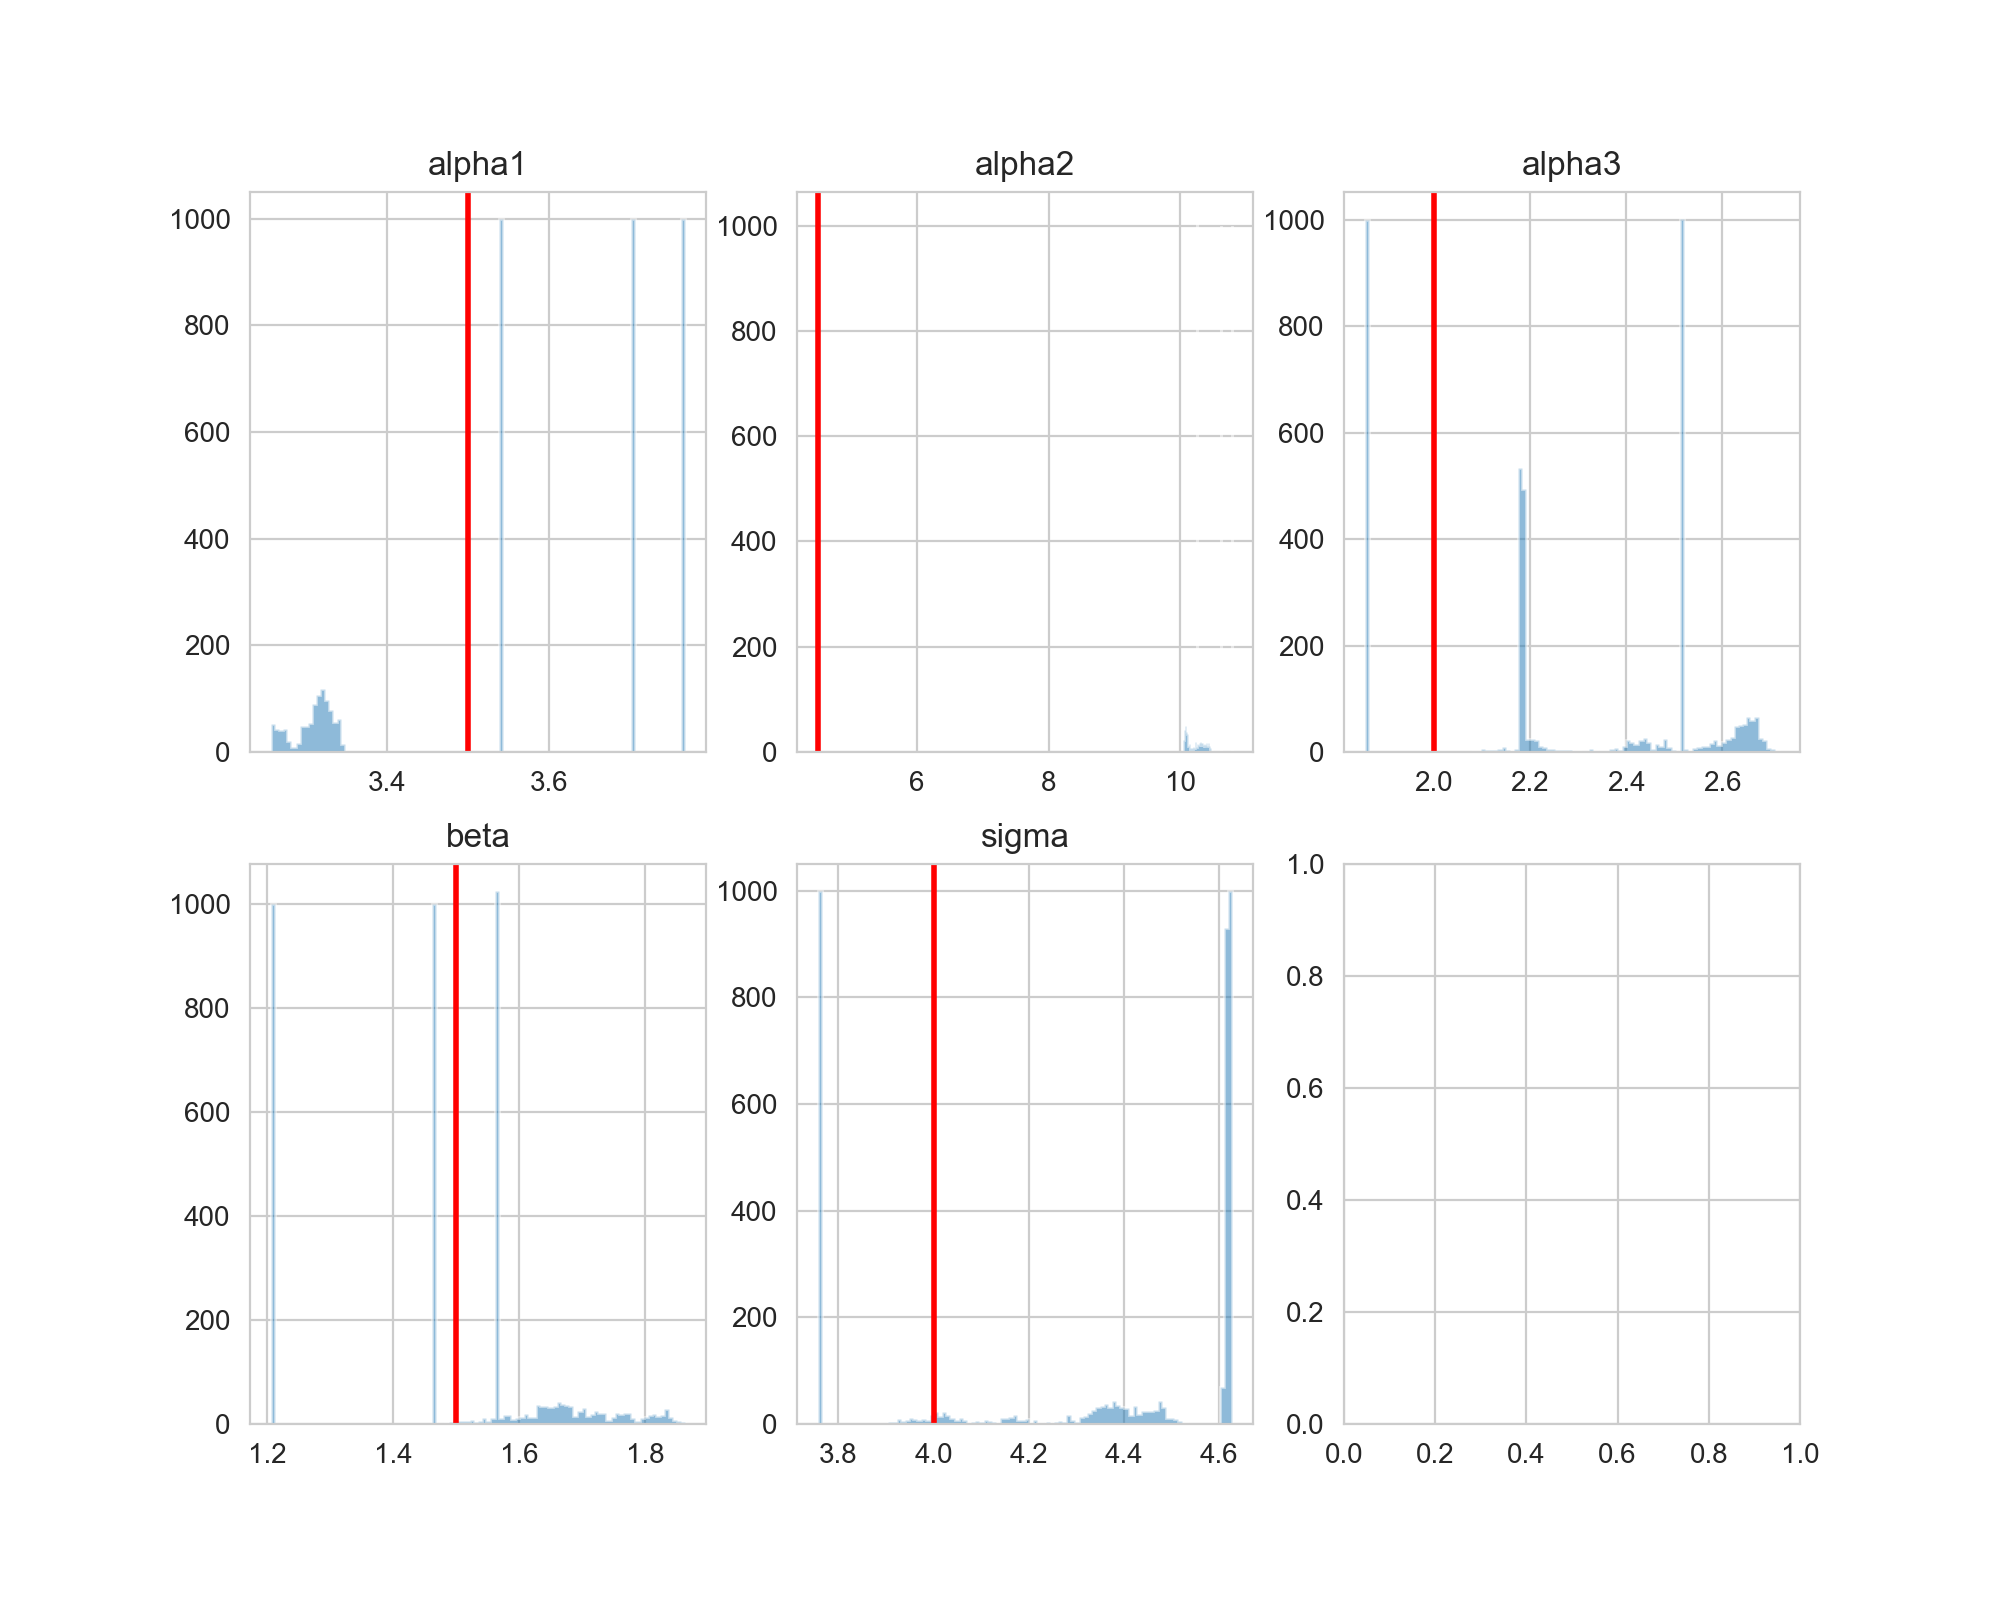

In [213]:
fig, axes = plt.subplots(2, 3, figsize=(10, 8))

axes = np.hstack(axes)

for i, vn in enumerate(var_names):
    axes[i].hist(samples[vn], bins=100, histtype="stepfilled", alpha=0.5)
    axes[i].set_title(vn)
    axes[i].axvline(true_pars[i], lw=2, color="red")

<IPython.core.display.Javascript object>


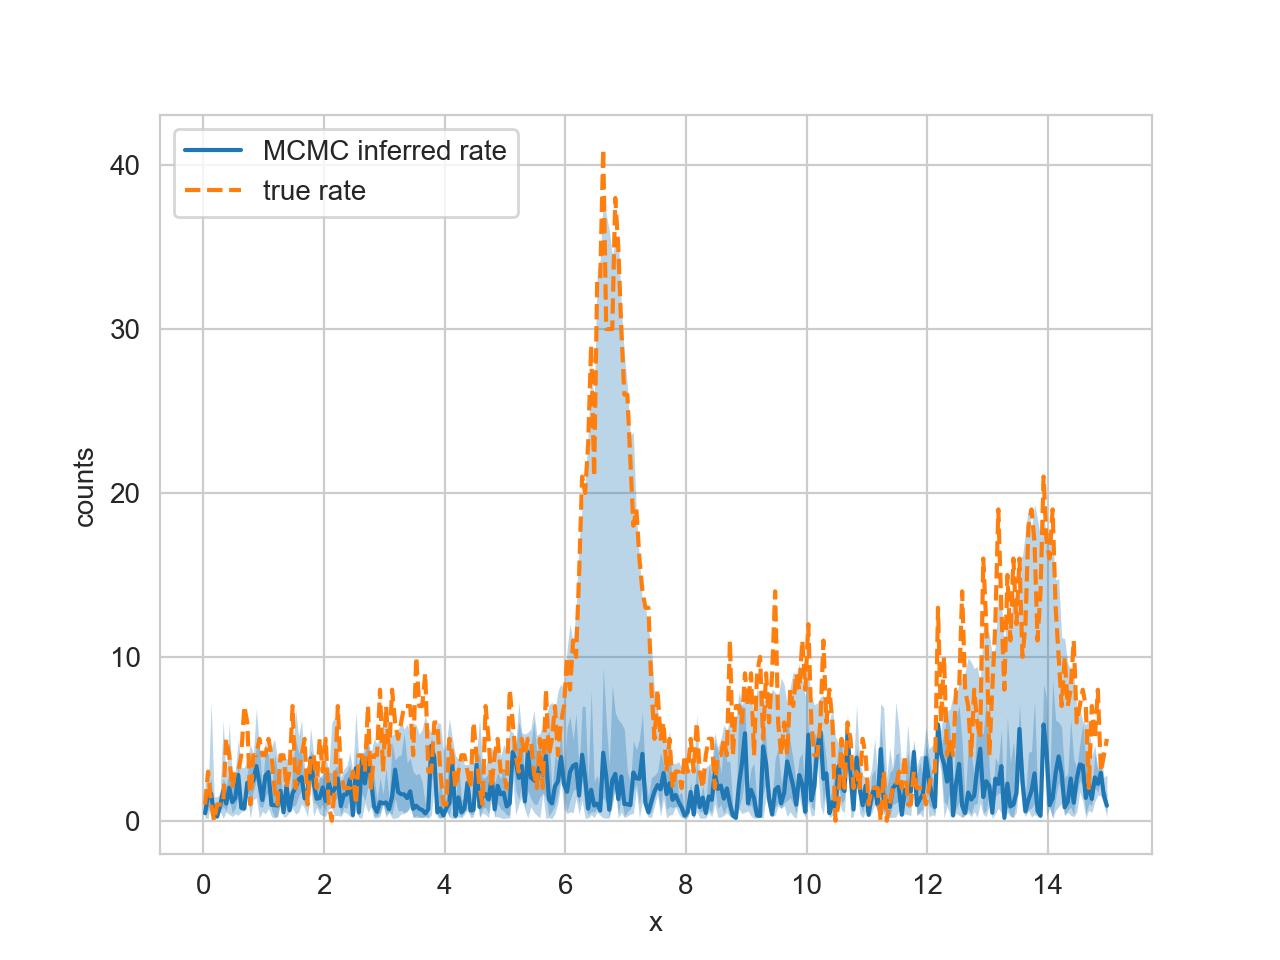

In [205]:
q = np.percentile(samples["log_rate"], [5, 25, 50, 75, 95], axis=0)
plt.figure()
plt.plot(time[:npoints], np.exp(q[2]), color="C0", label="MCMC inferred rate")
plt.fill_between(time[:npoints], np.exp(q[0]), np.exp(q[-1]), alpha=0.3, lw=0, color="C0")
plt.fill_between(time[:npoints], np.exp(q[1]), np.exp(q[-2]), alpha=0.3, lw=0, color="C0")
plt.plot(time[:npoints], sample[:npoints], "--", color="C1", label="true rate")
#plt.plot(x, y, ".k", label="data")
plt.legend(loc=2)
plt.xlabel("x")
_ = plt.ylabel("counts")


**I think this might be computationally unfeasible.** 

I'm going to go back to an additive model, and try that in numpyro

## Additive Model in Numpyro with CARMA

INFO[2023-10-06 15:19:35,262]: Checking if light curve is well behaved. This can take time, so if you are sure it is already sorted, specify skip_checks=True at light curve creation.
INFO[2023-10-06 15:19:35,263]: Checking if light curve is sorted.
INFO[2023-10-06 15:19:35,263]: Computing the bin time ``dt``. This can take time. If you know the bin time, please specify it at light curve creation


-56.12707048255925


<IPython.core.display.Javascript object>


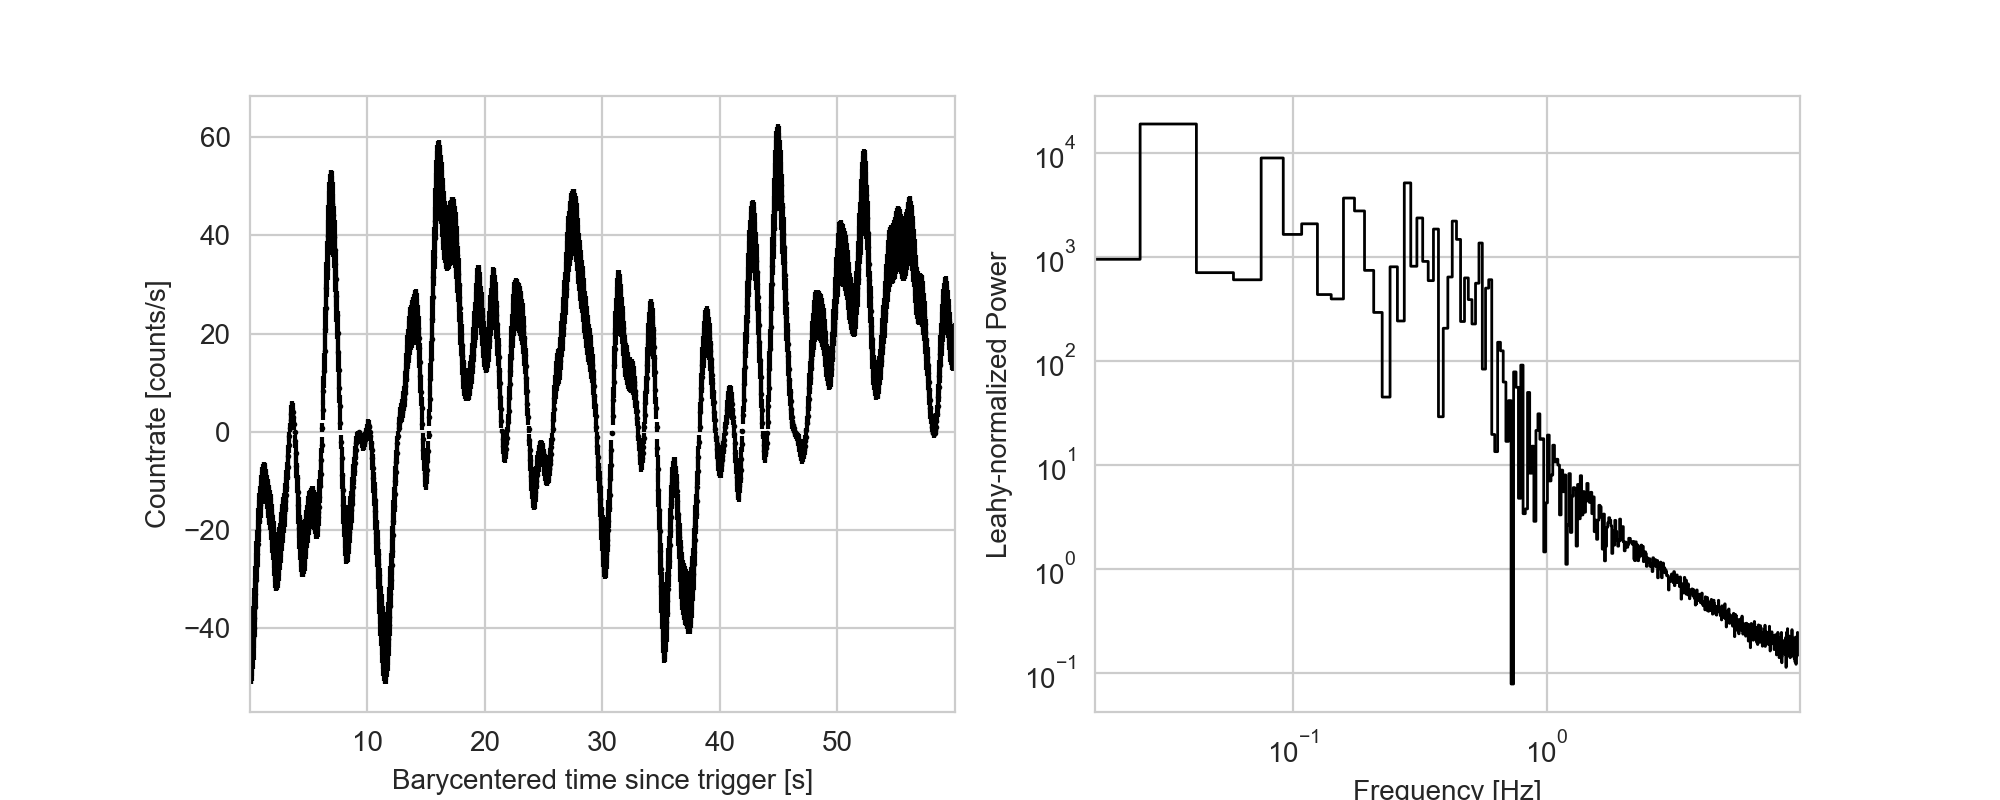

<IPython.core.display.Javascript object>


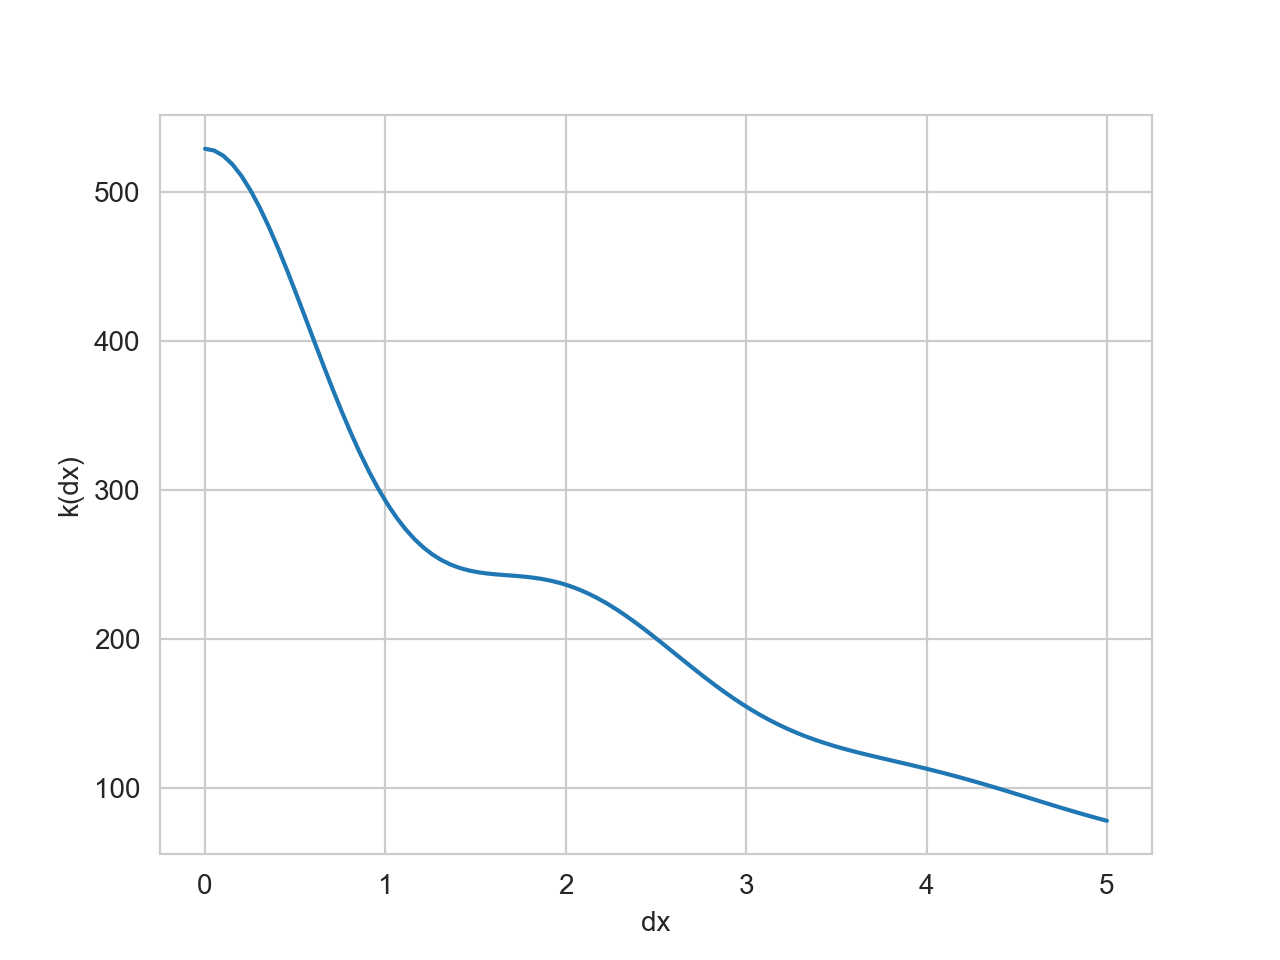

In [294]:
#alpha = [.8, 1.2, 1.7]
#beta = [1.5]
#sigma = 1e5

alpha = [3.5, 10.5, 2.0]
beta = [1.5]
sigma = 120

log_const = 4.0

skew_amp = 10
skew_t0 = 6.0
skew_sig1 = 2.0
skew_sig2 = 10.0


kernel_params_true = {"alpha": alpha,
                      "beta": beta,
                      "acarma": sigma}
mean_params_true = {"A": skew_amp, 
                    "t0": skew_t0, 
                    "sig1": skew_sig1, 
                    "sig2": skew_sig2,
                    "log_const": log_const}

time = lc.time

#mean = _skew_gaussian(time, mean_params_true)
#mean = np.ones_like(time) * np.exp(log_const)

kernel = CARMA.init(alpha=alpha, beta=beta, sigma=sigma)
gp = GaussianProcess(kernel, time, mean_value=np.zeros_like(time), diag=0.01)

key = random.PRNGKey(100)
#sample = np.exp(gp.sample(key) + mean)
sample = gp.sample(key)
#sample = np.random.poisson(sample)

#err = np.random.normal(0.0, np.sqrt(np.abs(sample)))
#sample = sample + err

gp.condition(sample)
print(gp.log_probability(sample))
lcsample = Lightcurve(time, sample)
pssample = Powerspectrum(lcsample, norm="leahy")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4))

ax1.errorbar(lcsample.time, lcsample.counts, yerr=np.sqrt(np.abs(lcsample.counts)), 
             fmt="o", markersize=1, color="black")
ax1.set_xlim(lcsample.time[0], lcsample.time[-1])
ax1.set_xlabel("Barycentered time since trigger [s]")
ax1.set_ylabel("Countrate [counts/s]")

ax2.loglog(pssample.freq, pssample.power, ds="steps-mid", lw=1, color="black")
ax2.set_xlim(pssample.freq[0], pssample.freq[-1])
ax2.set_xlabel("Frequency [Hz]")
ax2.set_ylabel("Leahy-normalized Power")
#ax1.set_ylim(0, 200)

def plot_kernel(kernel, **kwargs):
    dx = np.linspace(0, 5, 100)
    plt.figure()
    plt.plot(dx, kernel(dx, dx[:1]), **kwargs)
    plt.xlabel("dx")
    plt.ylabel("k(dx)")


plot_kernel(kernel)

In [295]:
sigma

120

In [296]:
def model(x, yerr, y=None):
    # The parameters of the GP model
    alpha1 = numpyro.sample("alpha1", dist.Uniform(3.0, 4.0))
    alpha2 = numpyro.sample("alpha2", dist.Uniform(4.0, 5.0))
    alpha3 = numpyro.sample("alpha3", dist.Uniform(1.0, 3.0))
    beta = numpyro.sample("beta", dist.Uniform(1.0, 2.0))
    sigma = numpyro.sample("sigma", dist.Uniform(3, 5))
    
    # Set up the kernel and GP objects
    kernel = CARMA.init(alpha=[alpha1, alpha2, alpha3], beta=beta, sigma=sigma)
    gp = GaussianProcess(kernel, x, diag=0.01, mean_value=jnp.zeros_like(x))

    numpyro.sample("gp", gp.numpyro_dist(), obs=y)

    if y is not None:
        numpyro.deterministic("pred", gp.condition(y, x).gp.loc)


In [297]:
nuts_kernel = numpyro.infer.NUTS(model, target_accept_prob=0.9)
mcmc = numpyro.infer.MCMC(
    nuts_kernel,
    num_warmup=1000,
    num_samples=1000,
    num_chains=2,
    progress_bar=True,
)

In [298]:
rng_key = jax.random.PRNGKey(55873)
npoints = 200
time = lcsample.time[:npoints]
counts = lcsample.counts[:npoints]
yerr = jnp.sqrt(counts)

mcmc.run(rng_key, time, yerr, y=counts)

sample: 100%|██████| 2000/2000 [07:15<00:00,  4.60it/s, 1023 steps of size 2.80e-06. acc. prob=0.88]


In [299]:
samples = mcmc.get_samples()
data = az.from_numpyro(mcmc)
az.summary(data, var_names=[v for v in data.posterior.data_vars if v != "pred"])

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
alpha1  3.620  0.239   3.382    3.859      0.168    0.142       3.0      11.0   
alpha2  4.478  0.336   4.142    4.815      0.237    0.200       3.0      13.0   
alpha3  2.628  0.110   2.518    2.737      0.077    0.065       3.0      25.0   
beta    1.860  0.003   1.858    1.863      0.002    0.002       3.0      11.0   
sigma   3.705  0.393   3.313    4.098      0.277    0.234       3.0      12.0   

        r_hat  
alpha1   1.91  
alpha2   2.42  
alpha3   1.92  
beta     2.09  
sigma    2.32

In [300]:
samples["pred"]

Array([[-4.54100302e+01, -4.50817608e+01, -4.44757661e+01, ...,
        -8.48333698e-01, -4.45857504e-01,  2.16947842e-02],
       [-4.54100304e+01, -4.50817608e+01, -4.44757661e+01, ...,
        -8.48333715e-01, -4.45857582e-01,  2.16946309e-02],
       [-4.54100303e+01, -4.50817608e+01, -4.44757660e+01, ...,
        -8.48333606e-01, -4.45857370e-01,  2.16949459e-02],
       ...,
       [-4.52663546e+01, -4.50134996e+01, -4.44735486e+01, ...,
        -8.01195117e-01, -3.28532217e-01,  2.17033112e-01],
       [-4.52663541e+01, -4.50134993e+01, -4.44735486e+01, ...,
        -8.01194995e-01, -3.28531886e-01,  2.17033675e-01],
       [-4.52663541e+01, -4.50134993e+01, -4.44735486e+01, ...,
        -8.01194861e-01, -3.28531609e-01,  2.17034096e-01]],      dtype=float64)

In [301]:
samples = mcmc.get_samples()

In [302]:
var_names = ["alpha1", "alpha2", "alpha3", "beta", "sigma"]
samples

{'alpha1': Array([3.381675  , 3.38167536, 3.38167576, ..., 3.85917223, 3.85917241,
        3.85917105], dtype=float64),
 'alpha2': Array([4.81464127, 4.81464162, 4.81464116, ..., 4.14212426, 4.14212365,
        4.14212221], dtype=float64),
 'alpha3': Array([2.51808943, 2.51809005, 2.51809141, ..., 2.7372974 , 2.73729778,
        2.73729962], dtype=float64),
 'beta': Array([1.86307655, 1.86307646, 1.86307689, ..., 1.85771554, 1.85771601,
        1.85771518], dtype=float64),
 'pred': Array([[-4.54100302e+01, -4.50817608e+01, -4.44757661e+01, ...,
         -8.48333698e-01, -4.45857504e-01,  2.16947842e-02],
        [-4.54100304e+01, -4.50817608e+01, -4.44757661e+01, ...,
         -8.48333715e-01, -4.45857582e-01,  2.16946309e-02],
        [-4.54100303e+01, -4.50817608e+01, -4.44757660e+01, ...,
         -8.48333606e-01, -4.45857370e-01,  2.16949459e-02],
        ...,
        [-4.52663546e+01, -4.50134996e+01, -4.44735486e+01, ...,
         -8.01195117e-01, -3.28532217e-01,  2.17033112e-01

In [303]:
alpha = [3.5, 4.5, 2.0]
beta = [1.5]
sigma = 4

true_pars = np.hstack([alpha, beta, sigma])

<IPython.core.display.Javascript object>


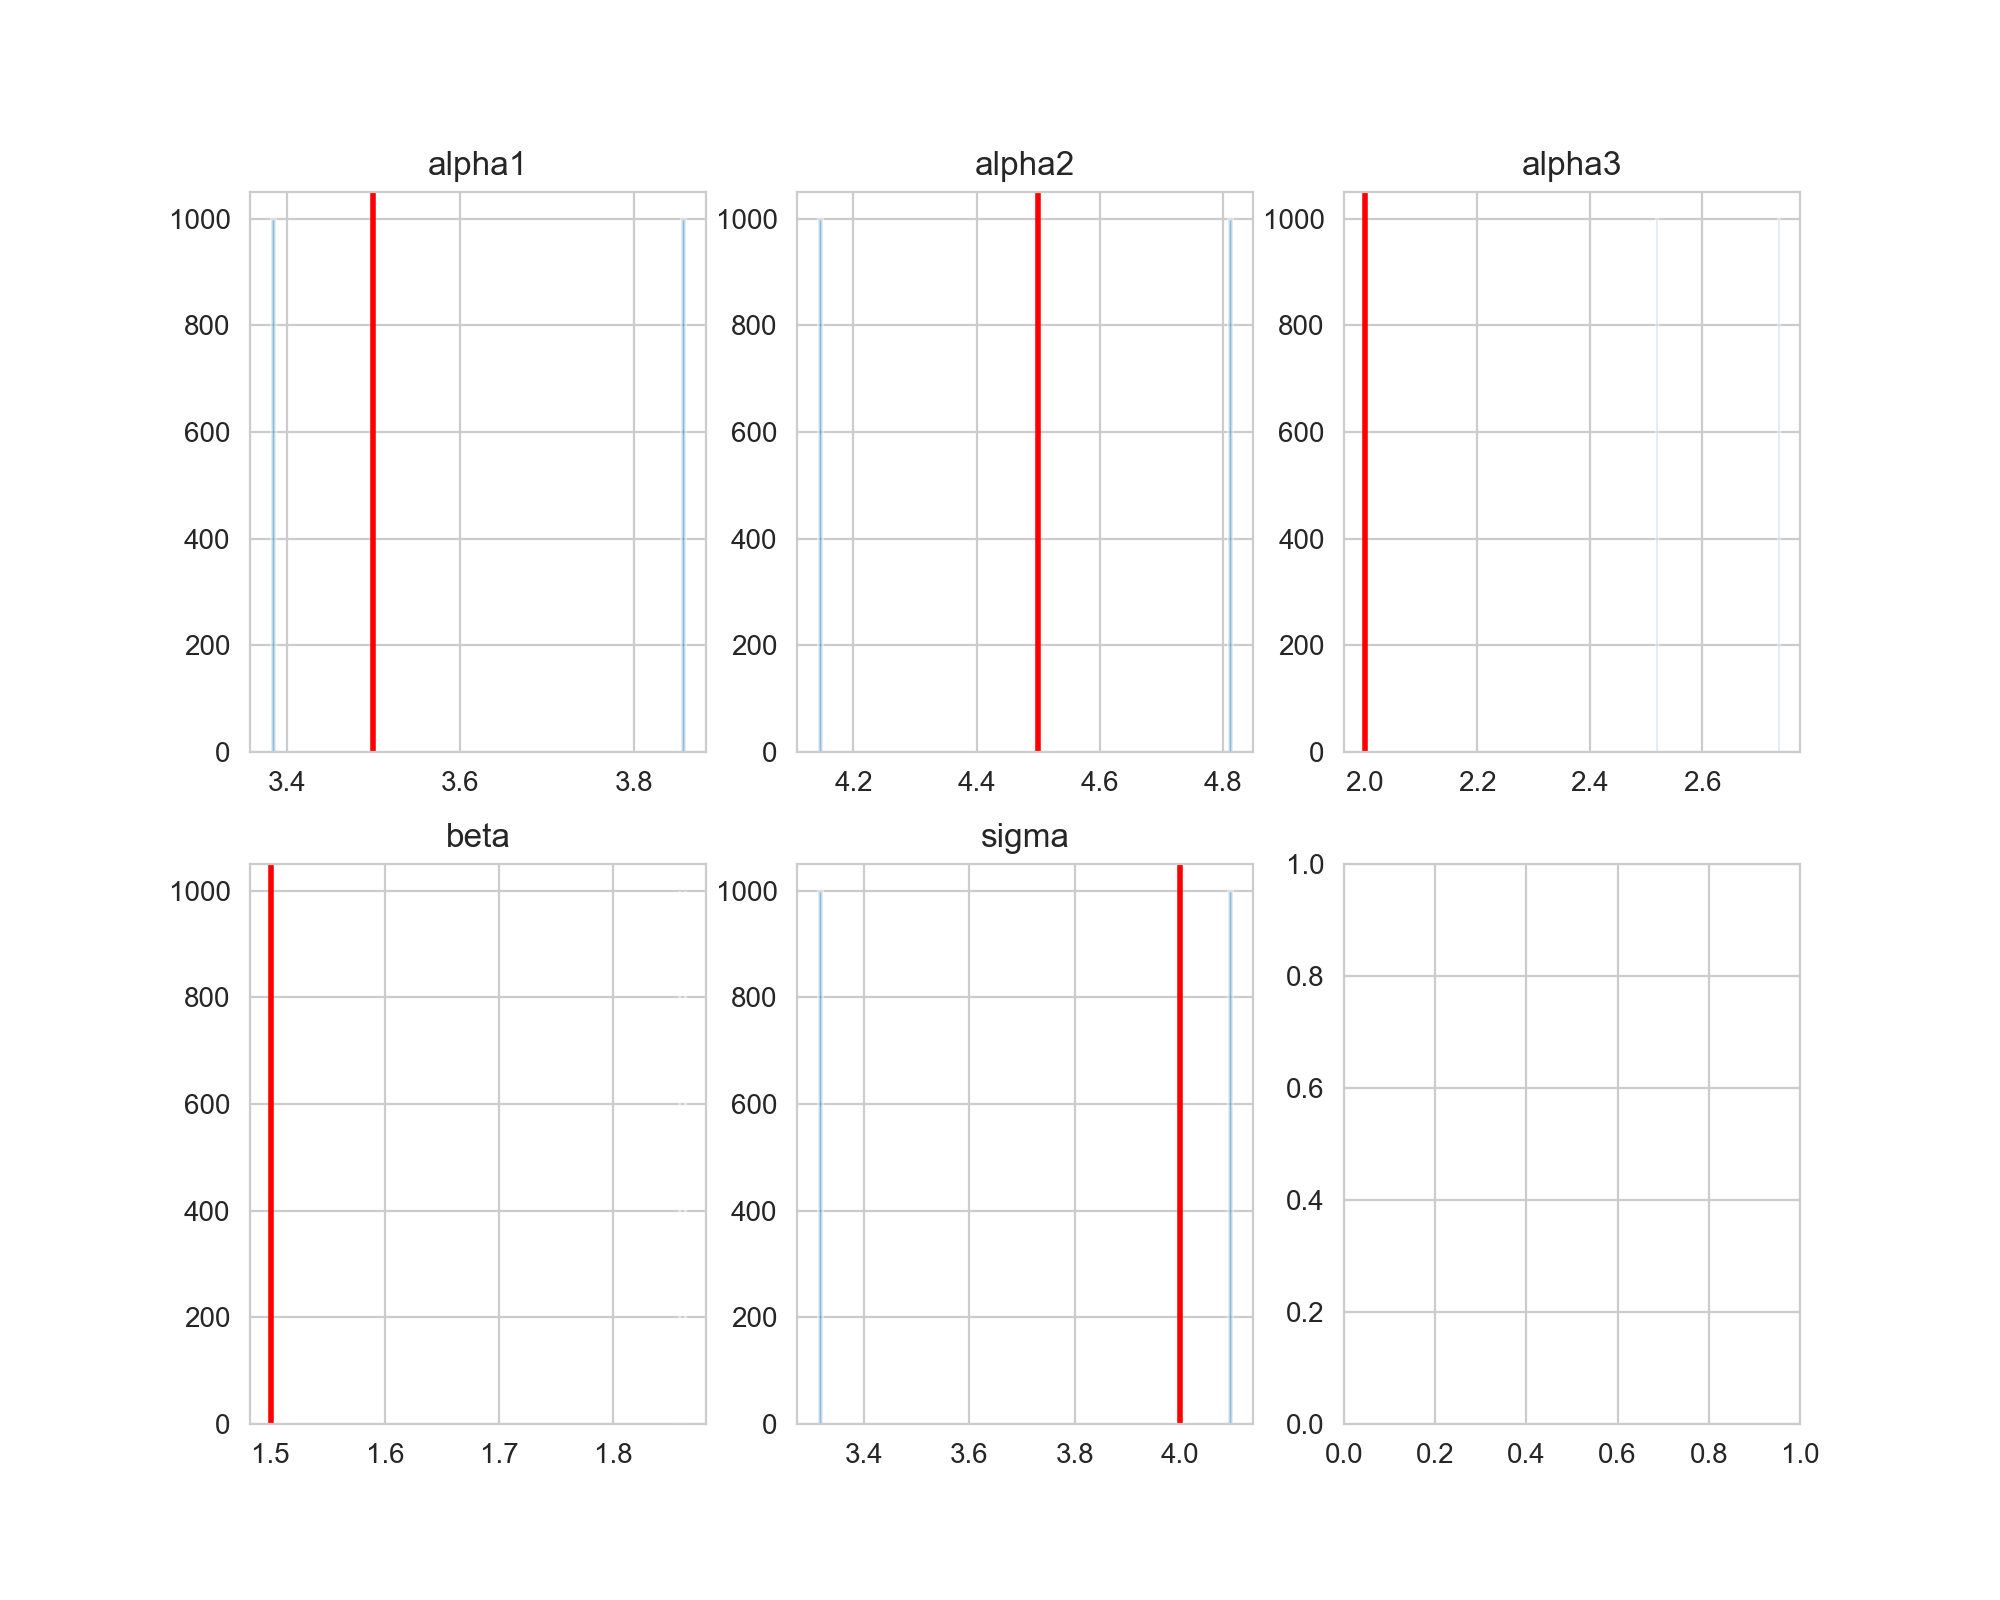

In [304]:

fig, axes = plt.subplots(2, 3, figsize=(10, 8))

axes = np.hstack(axes)

for i, vn in enumerate(var_names):
    axes[i].hist(samples[vn], bins=100, histtype="stepfilled", alpha=0.5)
    axes[i].set_title(vn)
    axes[i].axvline(true_pars[i], lw=2, color="red")

In [305]:
npoints

200

<IPython.core.display.Javascript object>


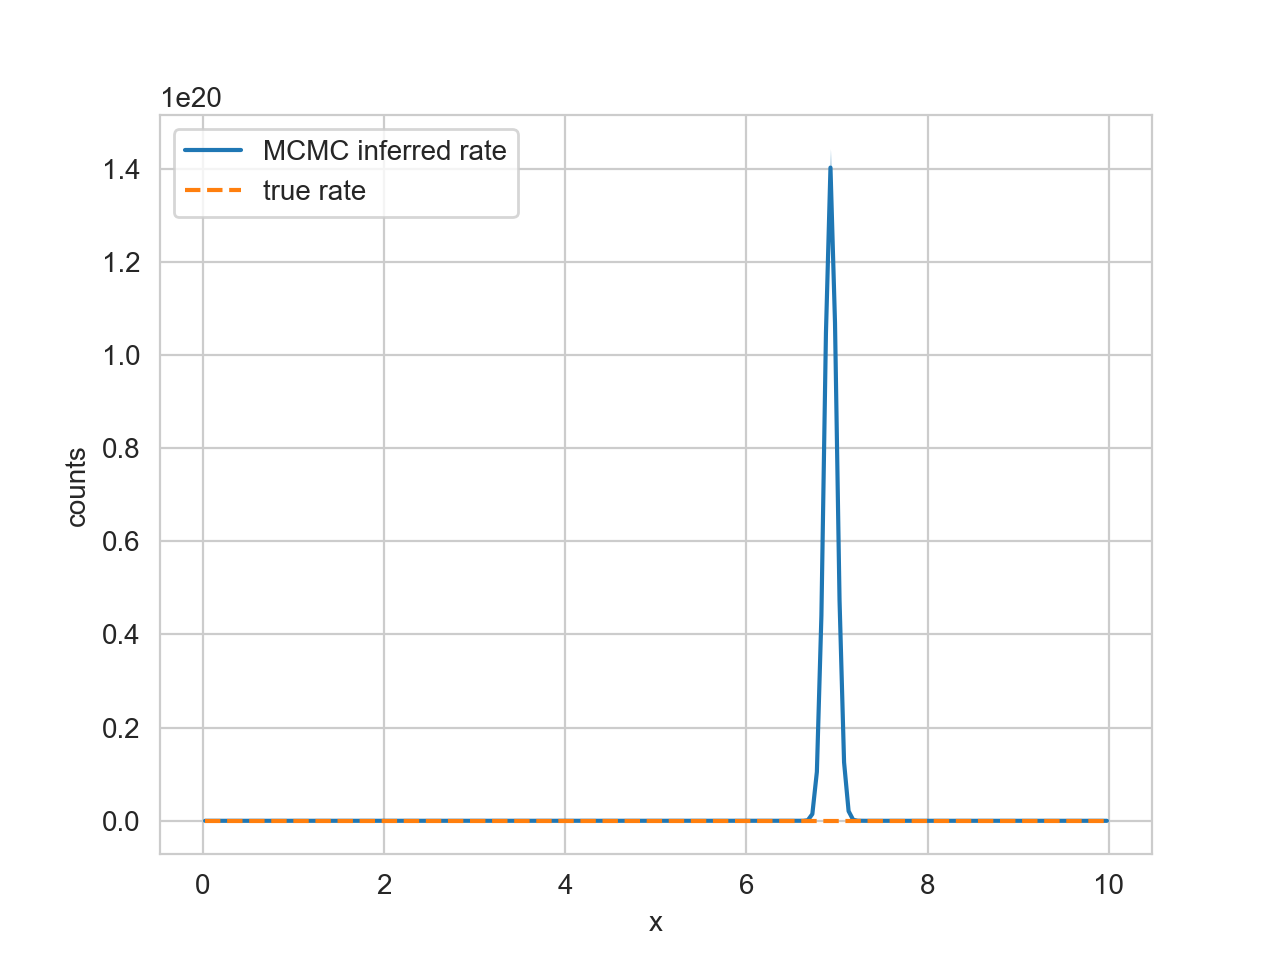

In [306]:
q = np.percentile(samples["pred"], [5, 25, 50, 75, 95], axis=0)
plt.figure()
plt.plot(time[:npoints], np.exp(q[2]), color="C0", label="MCMC inferred rate")
plt.fill_between(time[:npoints], np.exp(q[0]), np.exp(q[-1]), alpha=0.3, lw=0, color="C0")
plt.fill_between(time[:npoints], np.exp(q[1]), np.exp(q[-2]), alpha=0.3, lw=0, color="C0")
plt.plot(time[:npoints], sample[:npoints], "--", color="C1", label="true rate")
#plt.plot(x, y, ".k", label="data")
plt.legend(loc=2)
plt.xlabel("x")
_ = plt.ylabel("counts")
#plt.ylim(0, 100)

## CARMA Model

Let's build a CARMA model in TinyGP to do this modeling:

In [6]:
from tinygp.kernels.quasisep import CARMA
from tinygp import GaussianProcess

In [7]:
from functools import partial

INFO[2023-10-04 17:18:14,815]: Checking if light curve is well behaved. This can take time, so if you are sure it is already sorted, specify skip_checks=True at light curve creation.
INFO[2023-10-04 17:18:14,816]: Checking if light curve is sorted.
INFO[2023-10-04 17:18:14,817]: Computing the bin time ``dt``. This can take time. If you know the bin time, please specify it at light curve creation


<IPython.core.display.Javascript object>


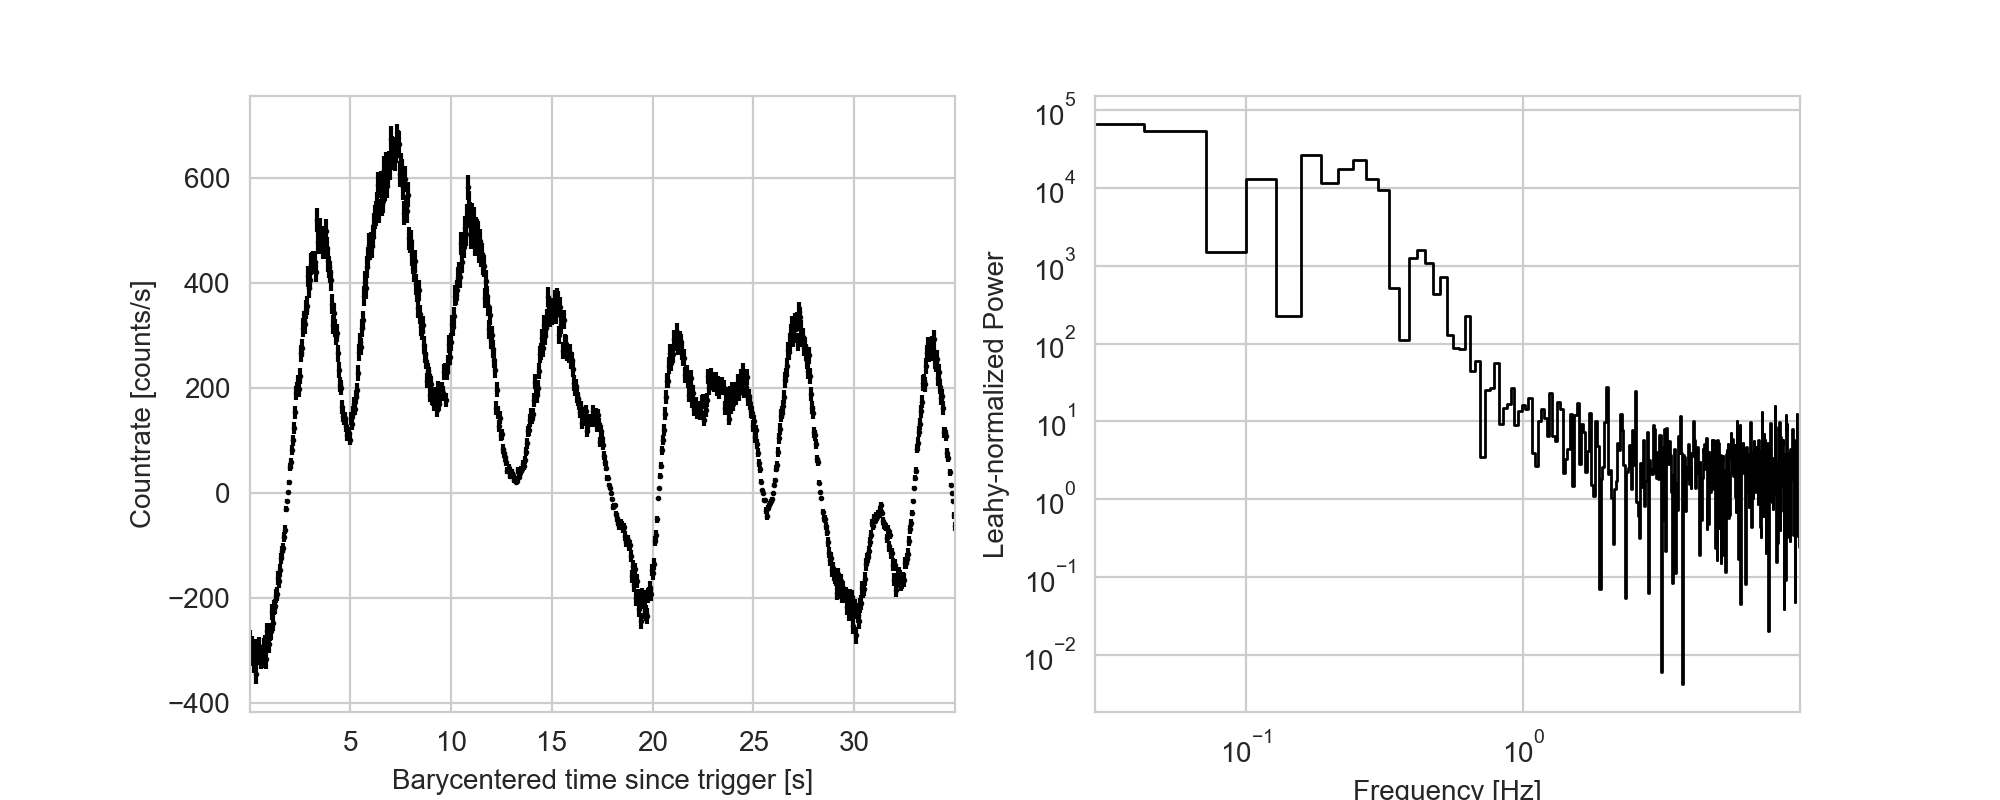

<IPython.core.display.Javascript object>


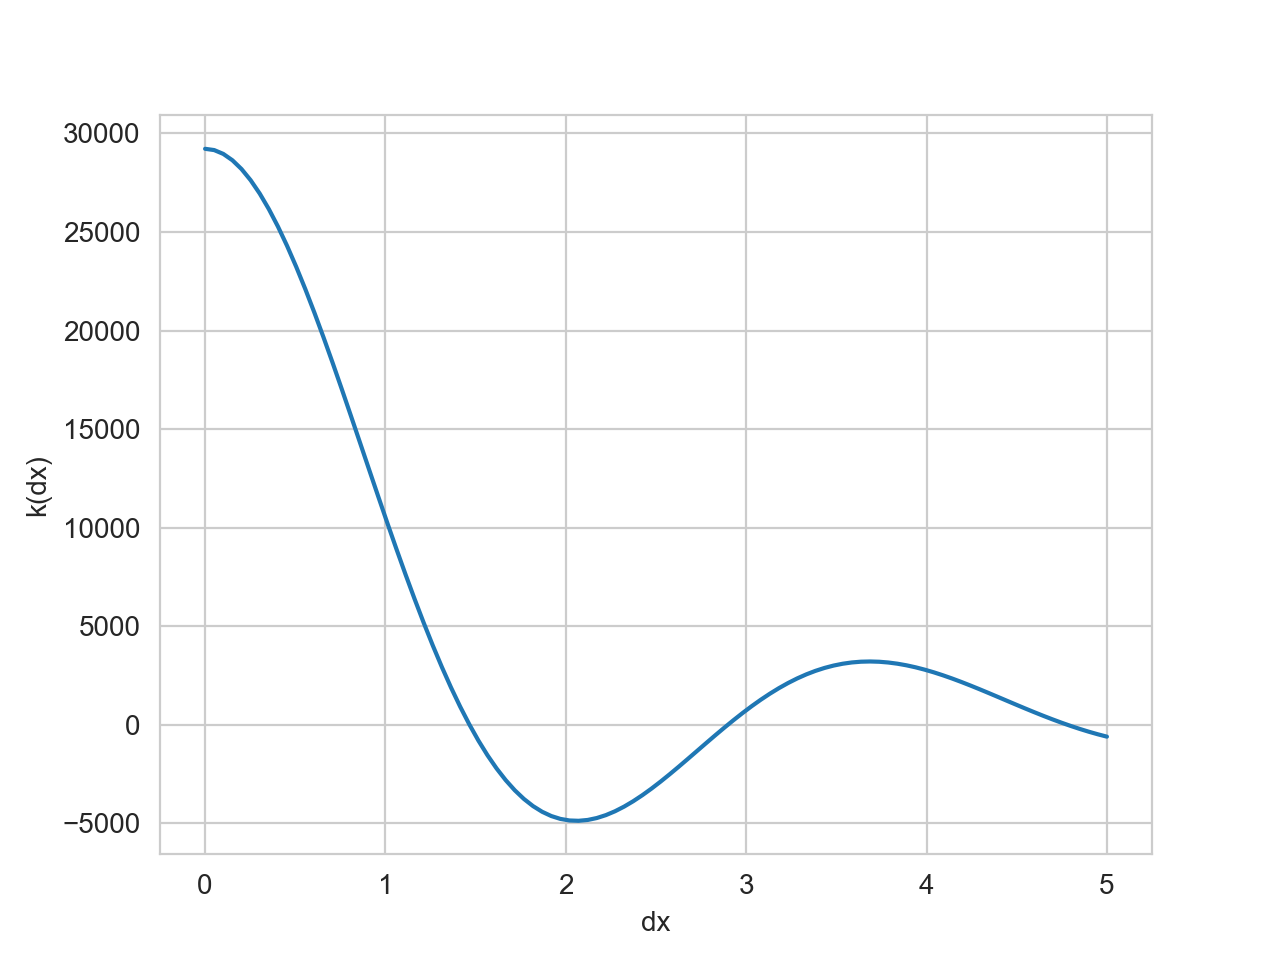

In [23]:
#alpha = [.8, 1.2, 1.7]
#beta = [1.5]
#sigma = 1e5

alpha = [3.5, 4.5, 2.0]
beta = [1.5]
sigma = 5e2

skew_amp = 2e2
skew_t0 = 6.0
skew_sig1 = 2.0
skew_sig2 = 10.0


kernel_params_true = {"alpha": alpha,
                      "beta": beta,
                      "acarma": sigma}
mean_params_true = {"A": skew_amp, 
                    "t0": skew_t0, 
                    "sig1": skew_sig1, 
                    "sig2": skew_sig2}

time = lc.time[:700]

mean = _skew_gaussian(time, mean_params_true)
#mean = np.ones_like(time)

kernel = CARMA.init(alpha=alpha, beta=beta, sigma=sigma)
gp = GaussianProcess(kernel, time, mean_value=mean, diag=0.1)

key = random.PRNGKey(100)
sample = gp.sample(key) + mean
err = np.random.normal(0.0, np.sqrt(np.abs(sample)))

sample = sample + err

lcsample = Lightcurve(time, sample)
pssample = Powerspectrum(lcsample, norm="leahy")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4))

ax1.errorbar(lcsample.time, lcsample.counts, yerr=np.sqrt(np.abs(lcsample.counts)), 
             fmt="o", markersize=1, color="black")
ax1.set_xlim(lcsample.time[0], lcsample.time[-1])
ax1.set_xlabel("Barycentered time since trigger [s]")
ax1.set_ylabel("Countrate [counts/s]")

ax2.loglog(pssample.freq, pssample.power, ds="steps-mid", lw=1, color="black")
ax2.set_xlim(pssample.freq[0], pssample.freq[-1])
ax2.set_xlabel("Frequency [Hz]")
ax2.set_ylabel("Leahy-normalized Power")

def plot_kernel(kernel, **kwargs):
    dx = np.linspace(0, 5, 100)
    plt.figure()
    plt.plot(dx, kernel(dx, dx[:1]), **kwargs)
    plt.xlabel("dx")
    plt.ylabel("k(dx)")


plot_kernel(kernel)

## Gaussian Process Analysis on the Full Light Curve

Let's do the GP Analysis on the full light curve. We start by comparing a Damped Random Walk with a QPO model:

In [24]:
kernel_type = "CARMA"
mean_type = "skew_gaussian"
params_list = get_gp_params(kernel_type= kernel_type, mean_type = mean_type)

print("parameters list", params_list)

parameters list ['log_alpha', 'log_beta', 'log_acarma', 'log_A', 't0', 'log_sig1', 'log_sig2']


In [25]:
times = lcsample.time
counts = lcsample.counts

In [30]:
np.log(kernel_params_true["acarma"])

6.214608098422191

In [31]:
#total_time = times[-1] - times[0]
#f = 1/(times[1]- times[0])
#span = jnp.max(counts) - jnp.min(counts)

# The prior dictionary, with suitable tfpd prior distributions
prior_dict = {
    "t0": tfpd.Uniform(low = 1.0, high = 10.0),
    "log_A": tfpd.Uniform(4, 8),
    "log_sig1": tfpd.Uniform(-1, 1),
    "log_sig2": tfpd.Uniform(1, 3.0),
    #"log_freq": tfpd.Uniform(0.3, 5.0),
    #"log_aqpo": tfpd.Uniform(2, 20),
    #"log_cqpo": tfpd.Uniform(-10, 10),
    "log_alpha": tfpd.Uniform(0, 2),
    "log_beta": tfpd.Uniform(0, 1),
    "log_acarma" : tfpd.Uniform(5, 8)
#    "log_arn": tfpd.Uniform(2, 20),
#    "log_crn": tfpd.Uniform(-10, 10)
}

params_list2 = ['log_alpha', 'log_beta', 'log_acarma', "log_A", "t0", "log_sig1", "log_sig2"]
#params_list2 = ['log_alpha', 'log_beta', 'log_acarma', "log_A"]

prior_model = get_prior(params_list2, prior_dict, p=3, q=1)

log_likelihood_model = get_log_likelihood(params_list2, kernel_type= kernel_type, mean_type = mean_type, 
                                          times = times, counts = counts, p=3, q=1, counts_err=0.1)

In [32]:
log_likelihood_model(np.log(alpha)[0], np.log(alpha)[1], np.log(alpha)[2], 
                     np.log(beta[0]), np.log(sigma),
                     jnp.log(mean_params_true["A"]), mean_params_true["t0"], 
                     jnp.log(mean_params_true["sig1"]), jnp.log(mean_params_true["sig2"]))

Array(-643053.55033801, dtype=float64)

In [33]:
from stingray.modeling.gpmodeling import GPResult

gpresult_rn = GPResult(lc = lc)
gpresult_rn.sample(prior_model = prior_model, likelihood_model = log_likelihood_model,
               max_samples=1e5)

INFO[2023-10-04 17:19:04,154]: Sanity check...
INFO[2023-10-04 17:19:04,159]: Sanity check passed


Simulation Complete


In [34]:
print("log Evidence: ", gpresult_rn.get_evidence())

log Evidence:  -562299.2308957216


In [35]:
gpresult_rn.results.samples

{'log_A0': Array([4.68543995, 5.35732576, 5.70247217, ..., 6.27131196, 6.27211436,
        6.27234409], dtype=float64),
 'log_acarma0': Array([7.76613046, 7.07087979, 7.24066046, ..., 7.99999548, 7.99999969,
        7.99999997], dtype=float64),
 'log_alpha0': Array([1.95881844, 1.95997833, 1.34080513, ..., 0.68186841, 0.68322284,
        0.68337577], dtype=float64),
 'log_alpha1': Array([1.3916083 , 0.04648893, 0.34264128, ..., 1.75402947, 1.75373979,
        1.75376439], dtype=float64),
 'log_alpha2': Array([0.49746718, 0.37305447, 0.41601093, ..., 0.00233636, 0.00091098,
        0.00077584], dtype=float64),
 'log_beta0': Array([0.45742628, 0.8729381 , 0.86903893, ..., 0.99999934, 0.99999784,
        0.99999298], dtype=float64),
 'log_sig10': Array([-0.57868844,  0.19918697,  0.95360623, ..., -0.90247321,
        -0.90258899, -0.9023021 ], dtype=float64),
 'log_sig20': Array([1.76528411, 2.46266584, 1.65562927, ..., 1.79319329, 1.79297627,
        1.79287164], dtype=float64),
 't00': 

<IPython.core.display.Javascript object>


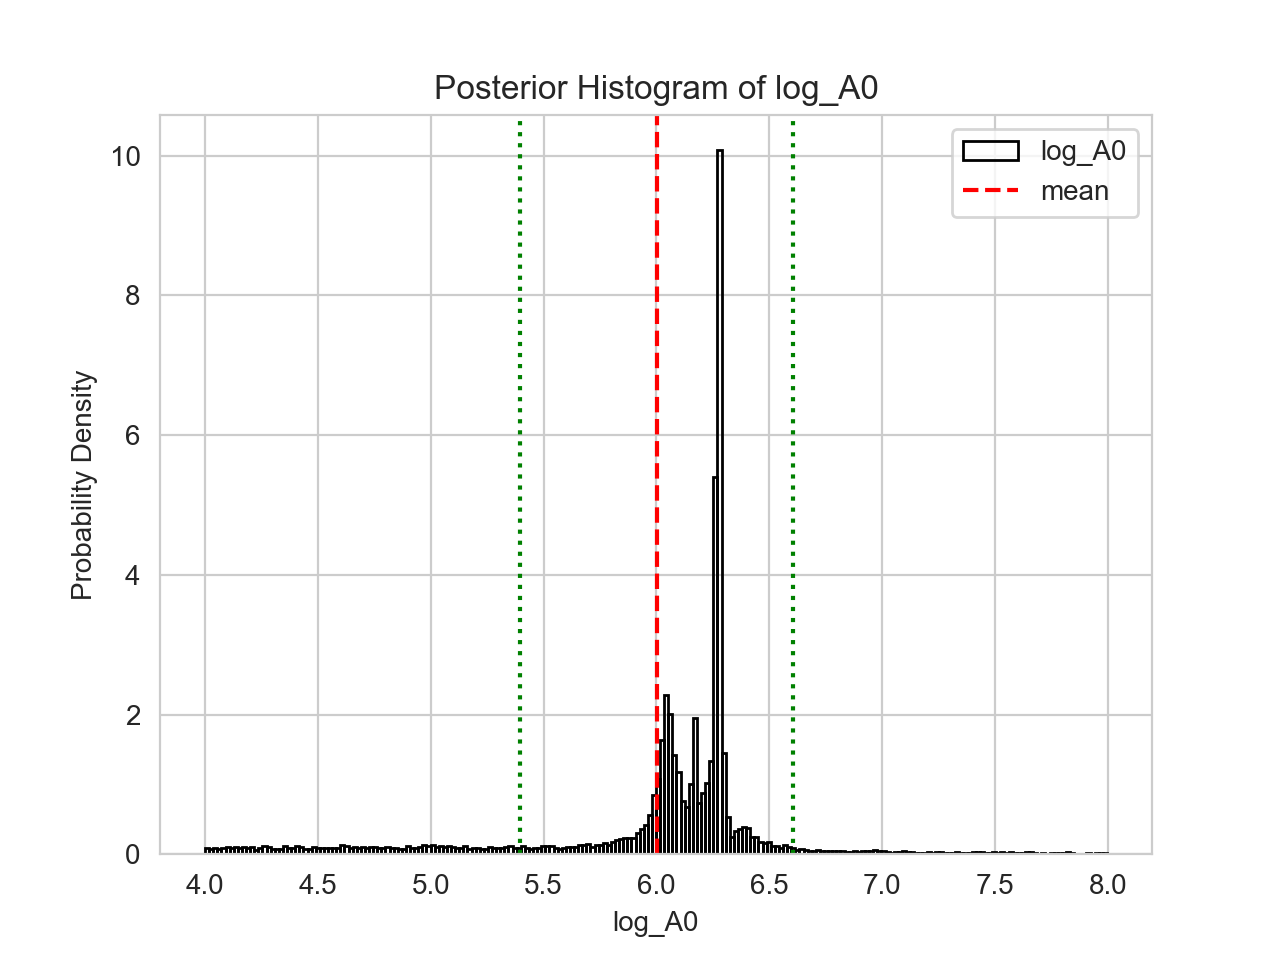

In [36]:
plt.figure()
plot = gpresult_rn.posterior_plot("log_A0")
plt.show()

In [37]:
gpresult_rn.print_summary()

--------
Termination Conditions:
Small remaining evidence
--------
# likelihood evals: 2411721
# samples: 29000
# slices: 729000.0
# slices / acceptance: 27.0
# likelihood evals / sample: 83.2
# likelihood evals / slice: 3.3
--------
logZ=-562299.23 +- 0.31
H=560000.0
ESS=2131
--------
log_A0: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
log_A0: 6.271 +- 0.025 | 6.263 / 6.276 / 6.286 | 6.272 | 6.272
--------
log_acarma0: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
log_acarma0: 7.999964 +- 3.7e-05 | 7.999917 / 7.999975 / 7.999997 | 8.0 | 8.0
--------
log_alpha0: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
log_alpha0: 0.6856 +- 0.0073 | 0.6804 / 0.685 / 0.6923 | 0.6834 | 0.6834
--------
log_alpha1: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
log_alpha1: 1.7514 +- 0.0068 | 1.7468 / 1.75 / 1.7547 | 1.7538 | 1.7538
--------
log_alpha2: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | m

<IPython.core.display.Javascript object>


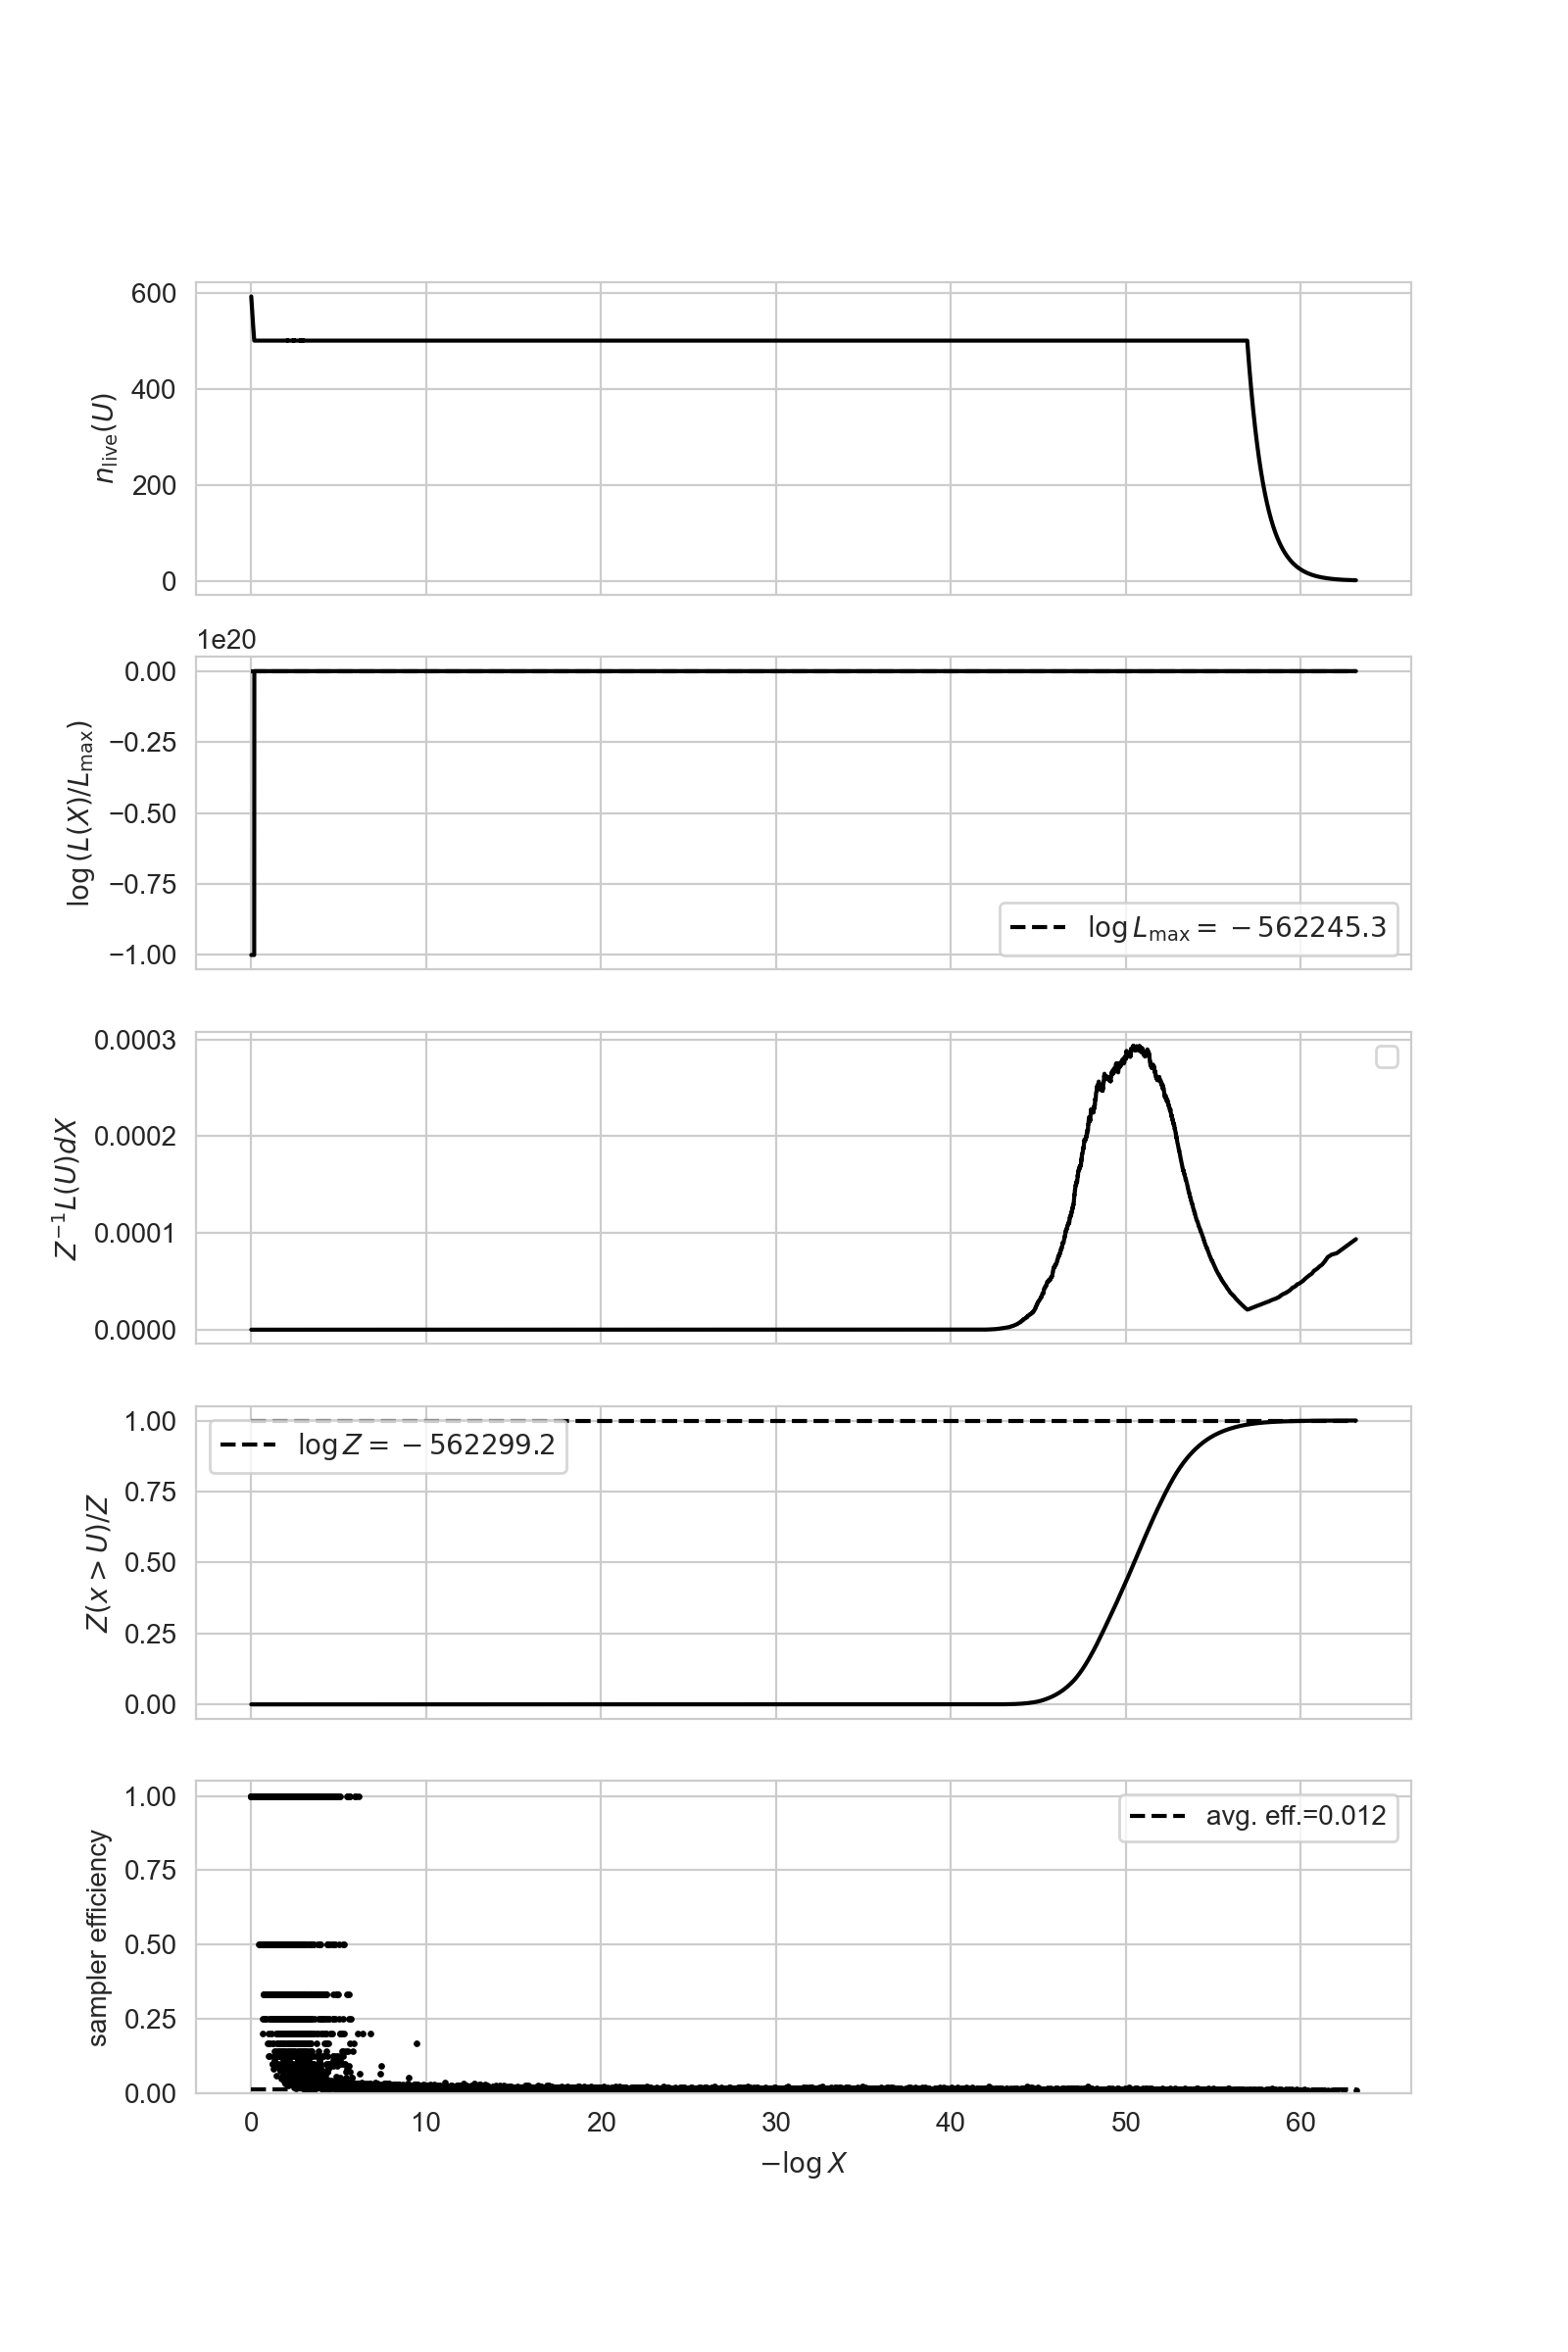

WARNING[2023-10-04 17:35:01,678]: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


In [38]:
gpresult_rn.exact_ns.plot_diagnostics(gpresult_rn.results)

<IPython.core.display.Javascript object>


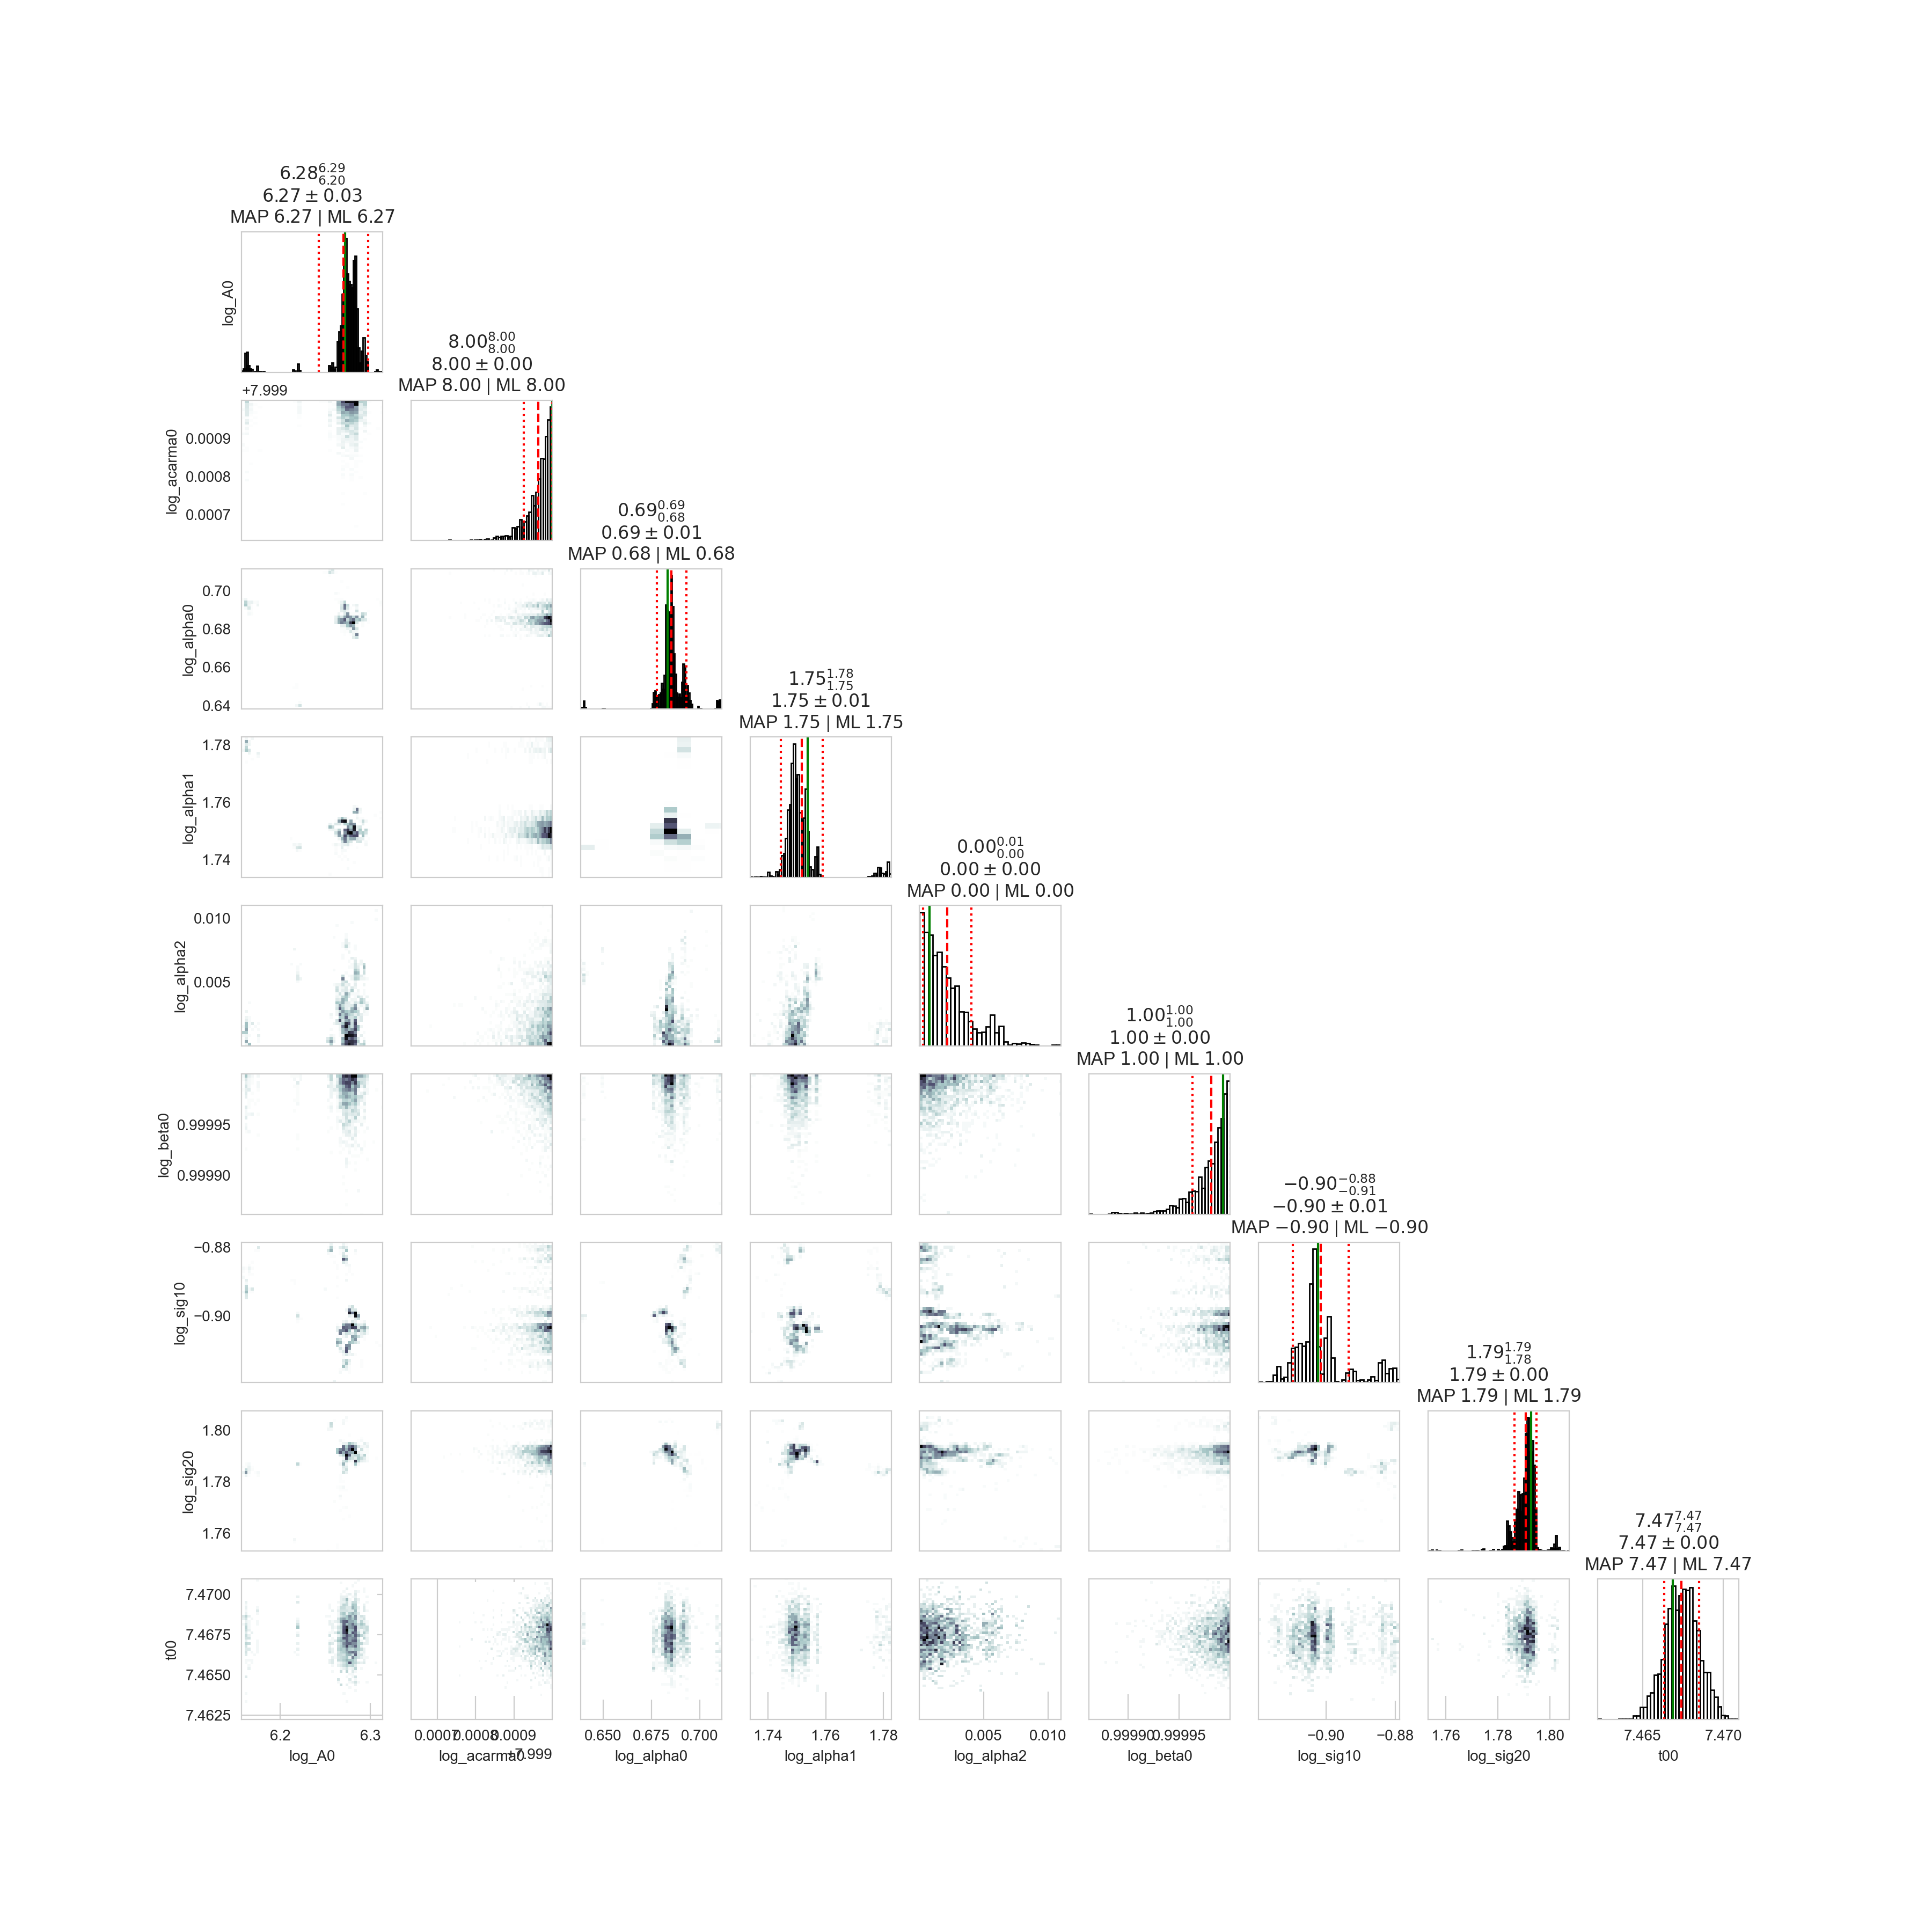

In [39]:
gpresult_rn.plot_cornerplot()

Let's write a function to plot the posterior predictive distribution (sort of):

In [40]:
def plot_posterior_predictive(lc, gpresult, kernel_type, mean_type, nmean=50,
                              ngrid=1000, ax=None, rkey=None, p=1, q=0, counts_err=None):
    """
    Plot the posterior predictive distribution.
    Will plot the maximum posterior for the Gaussian Process, and 
    `nsamples` random draws from the mean function.
    
    Parameters
    ----------
    lc : stingray.Lightcurve object
        The light curve with the time series data 
        being modelled
    
    nsresults : jaxns.Results object
        The results from the sampling
        
    kernel_type : str
        The kernel type used in the modeling
        
    mean_type : str
        The type of the mean function used
    
    nmean: int, default 50
        The number of samples to use for drawing the 
        posterior
        
    ngrid: int, default 1000
        The number of points in the linear grid to 
        use for plotting the Gaussian Process
    
    ax : matplotlib.Axes object, default None
        A matplotlib.Axes object to plot into. If none is 
        given, a new Figure object will be created
        
    rkey : jax.randomPRNGKey object
        A random key for setting the sampling. If None,
        set to random.PRNGKey(1234)
    
    p, q : int, int, default 1, 0
        If the kernel involves a CARMA model, then this 
        sets the orders of the AR and MA processes involved.
        Note that p >= q is required
    
    counts_err : array, default None
        if `None`, the error bars for the data will be set 
        to `sqrt(lc.counts)`, otherwise to whatever is set 
        for `counts_err`
    
    Returns
    -------
    ax : matplotlib.Axes object
        The matplotlib.axes object that the plot is 
        drawn in
    """
    if rkey is None:
        rkey = random.PRNGKey(1234)

    log_p = gpresult.results.log_dp_mean #log-prob
    nsamples = gpresult.results.total_num_samples # number of samples

    # array for resampled samples
    samples_resampled = {}

    # go through samples, resample with weights to get 
    # a weighted posterior sample
    for name in gpresult.results.samples.keys():
        samples = gpresult.results.samples[name]

        weights = jnp.where(jnp.isfinite(samples), jnp.exp(log_p), 0.0)
        log_weights = jnp.where(jnp.isfinite(samples), log_p, -jnp.inf)
        sr = resample(
            rkey, samples, log_weights, S=max(10, int(gpresult.results.ESS)), replace=True
    )
        samples_resampled[name] = sr

    print("Resampling done, calculating maximum posterior model ...")
    # split into samples belonging to the kernel, and samples 
    # belonging to the mean function
    kernel_params = stingray.modeling.gpmodeling._get_kernel_params(kernel_type)
    mean_params = stingray.modeling.gpmodeling._get_mean_params(mean_type)

    maxpost_log = gpresult.get_max_posterior_parameters()

    if not "CARMA" in kernel_type:
        mean_samples = dict((k, samples_resampled[k]) for k in mean_params)
        sk_maxpost_log = dict((k, maxpost_log[k]) for k in kernel_params)
        sm_maxpost_log = dict((k, maxpost_log[k]) for k in mean_params)
    else:
        mean_samples = dict((k, samples_resampled[k+"0"]) for k in mean_params)
        
        kernel_params_small = test_list = [i for i in kernel_params if not ('alpha' in i or 'beta' in i)]
        sk_maxpost_log = dict((k, maxpost_log[k+"0"]) for k in kernel_params_small)
        
        alpha, beta = [], []
        for j in range(p):
            print(j)
            if "log_alpha" in kernel_params:
                alpha.append(maxpost_log["log_alpha"+str(j)])
            else:
                alpha.append(maxpost_log["alpha"+str(j)])
        for k in range(q):
            print(k)
            if "log_beta" in kernel_params:
                beta.append(maxpost_log["log_beta"+str(k)])
            else:
                beta.append(maxpost_log["beta"+str(k)])
        
        sk_maxpost_log["log_alpha"] = alpha
        sk_maxpost_log["log_beta"] = beta

        #sk_maxpost_log = dict((k, maxpost_log[k]) for k in kernel_params)
        sm_maxpost_log = dict((k, maxpost_log[k+"0"]) for k in mean_params)

    sk_maxpost, sm_maxpost = {}, {}
    for params in kernel_params:
        if params[0:4] == "log_":
            sk_maxpost[params[4:]] = np.exp(sk_maxpost_log[params])
        else:
            sk_maxpost[params] = sk_maxpost_log[params]

    for params in mean_params:
        if params[0:4] == "log_":
            sm_maxpost[params[4:]] = np.exp(sm_maxpost_log[params])
        else:
            sm_maxpost[params] = sm_maxpost_log[params]
            
    kernel = get_kernel(kernel_type=kernel_type, kernel_params=sk_maxpost)
    mean = get_mean(mean_type=mean_type, mean_params=sm_maxpost)
    
    gp = GaussianProcess(kernel, lc.time, mean_value=mean(lc.time))
    tgrid = np.linspace(lc.time[0], lc.time[-1], ngrid)
    _, cond = gp.condition(lc.counts, tgrid)

    mu = cond.loc + mean(tgrid)
    std = np.sqrt(cond.variance)

    print("GP calculated, plotting GP and data ...")
    
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(8,4))

    if counts_err is None:
        counts_err = np.sqrt(lc.counts)
    ax.errorbar(lc.time, lc.counts, yerr=counts_err, 
                fmt="o", markersize=2, color="black",
                label="Observations")
    ax.plot(tgrid, mu, color="C0", label="Gaussian Process Maximum Posterior")
    ax.fill_between(tgrid, mu + std, mu - std, color="C0", alpha=0.3)

    idx_all = np.random.choice(np.arange(0,int(gpresult.results.ESS), 1.0, dtype=int), 
                               size=nmean,
                               replace=False)
    print("calculating and plotting mean functions ...")
    for i, idx in enumerate(idx_all):
        #sk_log = dict((k, kernel_samples[k][idx]) for k in kernel_params)
        sm_log = dict((k, mean_samples[k][idx]) for k in mean_params)
        sm = {}
        for params in mean_params:
            if params[0:4] == "log_":
                sm[params[4:]] = jnp.exp(sm_log[params])
            else:
                sm[params] = sm_log[params]

        mean = get_mean(mean_type=mean_type, mean_params=sm)
        mean_vals = mean(times)
        
        # legend only for the first line being drawn
        if i == 0:
            ax.plot(times, mean_vals, color="orange", 
                    alpha=0.1, label="Mean function posterior draws")  
        else:
            ax.plot(times, mean_vals, color="orange", alpha=0.1)

    # update legend opacity
    leg = ax.legend()
    for lh in leg.legendHandles: 
        lh.set_alpha(1)

    return ax

<IPython.core.display.Javascript object>


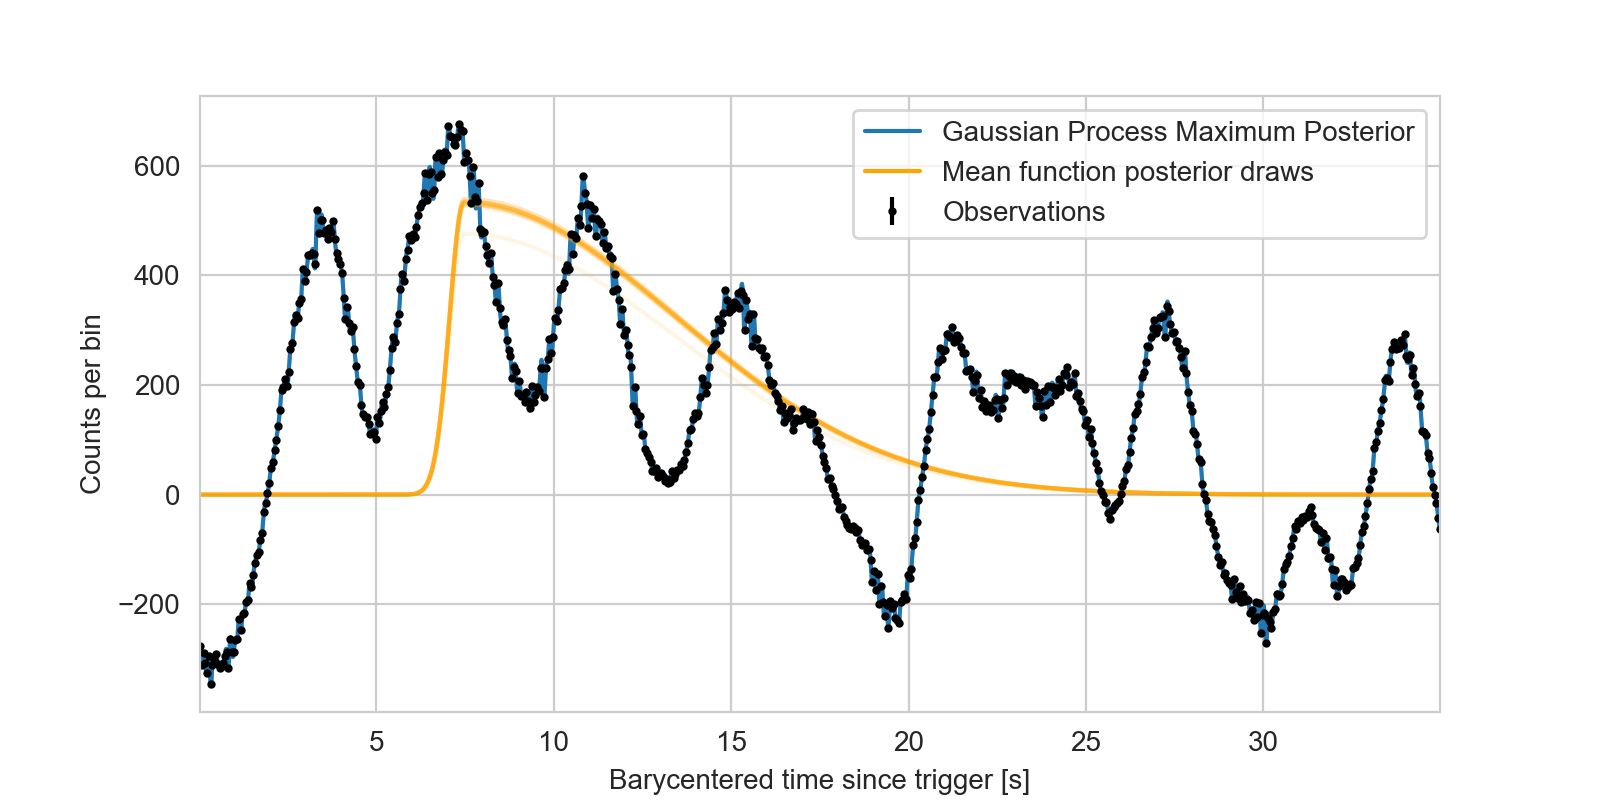

Resampling done, calculating maximum posterior model ...
0
1
2
0
GP calculated, plotting GP and data ...
calculating and plotting mean functions ...


Text(0, 0.5, 'Counts per bin')

In [41]:
fig, ax = plt.subplots(1, 1, figsize=(8,4))

ax = plot_posterior_predictive(lcsample, gpresult_rn, kernel_type, mean_type, 
                               nmean=20, ngrid=3000, ax=ax, rkey=None, p=3, q=1,
                               counts_err = np.ones_like(lcsample.time)*0.1)

ax.set_xlim(lcsample.time[0], lcsample.time[-1])
ax.set_xlabel("Barycentered time since trigger [s]")
ax.set_ylabel("Counts per bin")

## Red Noise + QPO

let's do a model with both red noise and a QPO:

In [ ]:
kernel_type = "QPO_plus_RN"
mean_type = "skew_gaussian"
params_list = get_gp_params(kernel_type= kernel_type, mean_type = mean_type)

print("parameters list", params_list)

In [ ]:
total_time = times[-1] - times[0]
f = 1/(times[1]- times[0])
span = jnp.max(counts) - jnp.min(counts)

# The prior dictionary, with suitable tfpd prior distributions
prior_dict = {
    "t0": tfpd.Uniform(low = 0.0, high = 20.0),
    "log_A": tfpd.Uniform(5, 15),
    "log_sig1": tfpd.Uniform(-1, 3.5),
    "log_sig2": tfpd.Uniform(1, 4.0),
    "log_freq": tfpd.Uniform(np.log(1.0), np.log(3.0)),
    "log_aqpo": tfpd.Uniform(2, 20),
    "log_cqpo": tfpd.Uniform(-10, 10),
    "log_arn": tfpd.Uniform(2, 20),
    "log_crn": tfpd.Uniform(-10, 10)
}

#params_list2 = ["log_arn", "log_crn", "log_A", "t0", "log_sig1", "log_sig2"]

prior_model = get_prior(params_list, prior_dict)

log_likelihood_model = get_log_likelihood(params_list, kernel_type= kernel_type, mean_type = mean_type, 
                                          times = times, counts = counts)

In [ ]:
from stingray.modeling.gpmodeling import GPResult

gpresult_qporn = GPResult(lc = lc)
gpresult_qporn.sample(prior_model = prior_model, likelihood_model = log_likelihood_model,
               max_samples=1e6)

In [ ]:
print("log Evidence: ", gpresult_rn.get_evidence())

In [ ]:
print("log Evidence: ", gpresult_qporn.get_evidence())

In [ ]:
gpresult_qporn.get_evidence() - gpresult_rn.get_evidence()

In [ ]:
plt.figure()
plot = gpresult_rn.posterior_plot("log_A")
plt.show()

In [ ]:
gpresult_qporn.print_summary()

In [ ]:
gpresult_qporn.exact_ns.plot_diagnostics(gpresult_qporn.results)

In [ ]:
gpresult_qporn.plot_cornerplot()

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(8,4))

ax = plot_posterior_predictive(lc, gpresult_qporn, kernel_type, mean_type, 
                               nmean=20, ngrid=3000, ax=ax, rkey=None)

ax.set_xlim(lc.time[0], lc.time[-1])
ax.set_xlabel("Barycentered time since trigger [s]")
ax.set_ylabel("Counts per bin")

Okay, that looks better. Phew. Let's plot the QPO frequency:

In [ ]:
plt.figure()
gpresult_qporn.posterior_plot("log_freq")

In [ ]:
samples = gpresult_qporn.results.samples["log_freq"]
rkey = random.PRNGKey(1234)

log_p = gpresult_qporn.results.log_dp_mean #log-prob
nsamples = gpresult_qporn.results.total_num_samples # number of samples

weights = jnp.where(jnp.isfinite(samples), jnp.exp(log_p), 0.0)
log_weights = jnp.where(jnp.isfinite(samples), log_p, -jnp.inf)
freq_resampled = resample(
    rkey, samples, log_weights, S=max(10, int(gpresult_qporn.results.ESS)), replace=True
)

In [ ]:
freq = np.exp(freq_resampled)
period = 1.0/freq

In [ ]:
period

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8,4))

ax1.hist(freq, bins=100, histtype="stepfilled", alpha=0.5)
ax1.set_xlabel("Frequency [Hz]")

ax2.hist(period, bins=100, histtype="stepfilled", alpha=0.5)
ax2.set_xlabel("Period [s]")

In [ ]:
np.log10(np.exp(gpresult_qporn.get_evidence() - gpresult_rn.get_evidence()))